In [ ]:
import sys
sys.path.append('../src')

import warnings
warnings.filterwarnings("ignore", message="Parsing dates in .* when dayfirst=True was specified")
warnings.filterwarnings("ignore", category=FutureWarning)

from preprocessing import *
import tame
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
from config import CONFIG

import matplotlib.pyplot as plt
import numpy as np
import shap 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader, Subset, random_split, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _cuda(obj):
    if isinstance(obj, torch.nn.Module):
        return obj.cuda()
    elif isinstance(obj, torch.Tensor):
        return obj.cuda()
    elif isinstance(obj, np.ndarray):
        return torch.from_numpy(obj).cuda()
    
def index_value(data):
    index = data // (CONFIG['split_num'] + 1)
    value = data % (CONFIG['split_num'] + 1)
    index = Variable(_cuda(index))
    value = Variable(_cuda(value))
    return [index, value]

In [2]:
dfs = get_dfs()
biopsy_df = dfs['biopsy'].copy()
static_df = create_static_df(dfs)
vital_df = create_vitals_df(dfs, static_df)
med_df = create_medication_df(dfs, static_df)
lab_df = create_lab_values_df(dfs, static_df)
ts_data = create_ts_df(vital_df, lab_df, med_df, merge_lab=True, merge_med=True)
print(ts_data.columns)

max rel_days 8034
max number of rows across all patients 1105
Index(['patient_id', 'transplant_id', 'rel_days', 'bp_sys', 'bp_dia', 'weight',
       'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin',
       'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01',
       'L04AD02'],
      dtype='object')


In [3]:
full_dataset = NephroDataset(static_df, ts_data, biopsy_df, phase='test')
categorical_card = full_dataset.categorical_cardinalities
#balanced_dataset = get_balanced_subset(full_dataset, samples_per_class=50)
#datapoint_limit = 1000
#dataset = Subset(full_dataset, range(datapoint_limit))
train_size = int(0.7 * len(full_dataset))
#t_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

batch_size = CONFIG['batch_size']
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Full dataset size: {len(full_dataset)}")

Train dataset size: 2172
Test dataset size: 931
Full dataset size: 3103


In [ ]:
checkpoint = torch.load('../model_checkpoints/models/best.ckpt', weights_only=False)
print(checkpoint.keys())
print(checkpoint['state_dict'].keys())

model = tame.AutoEncoder(categorical_cardinalities=categorical_card)
model.load_state_dict(checkpoint['state_dict'])

dict_keys(['epoch', 'best_metric', 'state_dict', 'best r2s'])
odict_keys(['embedding.weight', 'value_embedding.weight', 'static_encoder.embeddings.0.weight', 'static_encoder.embeddings.1.weight', 'static_encoder.embeddings.2.weight', 'static_encoder.embeddings.3.weight', 'static_encoder.embeddings.4.weight', 'static_encoder.embeddings.5.weight', 'static_encoder.embeddings.6.weight', 'static_encoder.embeddings.7.weight', 'static_encoder.numerical_processor.0.weight', 'static_encoder.numerical_processor.0.bias', 'static_encoder.fc.weight', 'static_encoder.fc.bias', 'value_mapping.0.weight', 'value_mapping.0.bias', 'mapping.0.weight', 'mapping.0.bias', 'mapping.2.weight', 'mapping.2.bias', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l0_reverse', 'lstm.weight_hh_l0_reverse', 'lstm.bias_ih_l0_reverse', 'lstm.bias_hh_l0_reverse', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'lstm.weight_ih_l1_reverse', 'ls

<All keys matched successfully>

In [ ]:
def extract_horizon_reps(model, data_loader, horizons, target, label_rel_days):
    patient_sample_counts = {H: {} for H in horizons}

    # For each horizon, prepare storage for hidden reps, labels, day-of-step, patient_id
    hr_repr = {H: [] for H in horizons}
    hr_label = {H: [] for H in horizons}
    hr_days  = {H: [] for H in horizons}
    hr_pids  = {H: [] for H in horizons}
    hr_loss_days = {H: [] for H in horizons}

    model.eval()
    with torch.no_grad():
        
        for batch in tqdm(data_loader):
            pid = batch['patient_id']

            # Data with real values with rel_days(time)
            real_data = Variable(_cuda(batch['real_ts_data']))

            # Time series features
            ts_data = index_value(batch['input_ts_features'])
            #print(batch['input_ts_features'].shape) # (B, T, F) T==200
            neib = [index_value(batch['pre_input']), Variable(_cuda(batch['pre_time'])), index_value(batch['post_input']), Variable(_cuda(batch['post_time']))]

            # Static features
            static_num = Variable(_cuda(batch['static_numerical_features']))
            static_cat = Variable(_cuda(batch['static_categorical_features']))

            pad_mask = Variable(_cuda(batch['mask']))
            lstm_out = model(ts_data, neib, static_num, static_cat, mask=pad_mask, get_embedding=True) # (B, T, 2* embedding_dim)


            label = batch[target]
            labels_data = []
            for lb in label:
                if isinstance(lb, torch.Tensor):
                    if lb.numel() == 1:
                        lb = float(lb.item())
                    else:
                        lb = lb.cpu().numpy()
                labels_data.append(lb)

            # Convert rel_days to numpy array
            if label_rel_days is not None and label_rel_days in batch:
                raw_rel_days_data = batch[label_rel_days]
                rel_days_data = []
                for d in raw_rel_days_data:
                    if isinstance(d, torch.Tensor):
                        if d.numel() == 1:
                            d = float(d.item())
                        else:
                            d = d.cpu().numpy()
                    rel_days_data.append(d)
                rel_days_data = np.array(rel_days_data)
            else: 
                rel_days_data = None

            seq_lens = batch['seq_len']
            for i in range(lstm_out.shape[0]):
                patient_id_i = pid[i]

                label_i = labels_data[i] # this can be single label or list of event days
                seq_len = seq_lens[i].item()
                seq_len = min(seq_len, real_data.shape[1])  # clip to max available length

                if seq_len < 2:
                    continue

                tm_i = real_data[i, :seq_len, 0].cpu().numpy().flatten() #time steps

                for k in range(1, seq_len):
                    curr_day = tm_i[k]
                    #norm_curr_day = norm_tm_i[k]
                    
                    if curr_day < 30: # Get the embedddings for day 30 and more
                        continue

                    rep = lstm_out[i, k, :].cpu().numpy()

                    for H in horizons:
                        if patient_id_i not in patient_sample_counts[H]:
                            patient_sample_counts[H][patient_id_i] = 0

                        if rel_days_data is not None:
                            event_label = label_i # 0 or 1 
                            rel_day = rel_days_data[i]
                            hr_loss_days[H].append(rel_day)
                            if (event_label == 1) and (curr_day > rel_day):
                                #print(f"Skipping embedding for patient {patient_id_i}, curr_day {curr_day}, rel_day {rel_day}")
                               continue  # skip embeddings after loss

                            elif (event_label == 1) and (0 <= (rel_day - curr_day) <= H):
                                label_ = 1
                            else:
                                label_ = 0

                        # Else multi-event logic (like rejections)
                        else:
                            # label_or_list is a list of event days or None
                            if isinstance(label_i, (list, np.ndarray)) and len(label_i) > 0:
                                # label_ = 1 if any day d in label_or_list satisfies (0 < d - cur_day <= H)
                                label_i = [float(d) for d in label_i if d is not None and str(d) != 'nan']
                                label_ = int(any(0 < (d - curr_day) <= H for d in label_i))
                            else:
                                label_ = 0
                    
                        hr_repr[H].append(rep)
                        hr_label[H].append(label_)
                        hr_days[H].append(curr_day)
                        hr_pids[H].append(patient_id_i)
                        

                        patient_sample_counts[H][patient_id_i] += 1
    for H in horizons:
        hr_repr[H] = np.array(hr_repr[H])
        hr_label[H] = np.array(hr_label[H])
        hr_days[H] = np.array(hr_days[H])
        hr_pids[H] = np.array(hr_pids[H])
        hr_loss_days[H] = np.array(hr_loss_days[H])
    # Calculate and print statistics
    for H in horizons:
        total_patients = len(patient_sample_counts[H])
        avg_samples = np.mean([patient_sample_counts[H][pid] for pid in patient_sample_counts[H]])
        max_samples = max([patient_sample_counts[H][pid] for pid in patient_sample_counts[H]]) if patient_sample_counts[H] else 0
        
        print(f"Horizon {H}: {total_patients} patients, avg {avg_samples:.1f} samples/patient, max {max_samples} samples/patient")

    return hr_repr, hr_label, hr_days, hr_pids, hr_loss_days

In [7]:
model = model.to(device)
horizons = [30, 90, 180, 360]
print("Graft Loss:")
train_graft_repr, train_graft_lbl, train_graft_days, train_graft_pids, train_loss_days = extract_horizon_reps(model, train_dataloader, horizons, 'graft_loss_label', 'loss_rel_days')
test_graft_repr, test_graft_lbl, test_graft_days, test_graft_pids, test_loss_days = extract_horizon_reps(model, test_dataloader, horizons, 'graft_loss_label', 'loss_rel_days')
print("Rejection:")
train_rej_repr, train_rej_lbl, train_rej_days, train_rej_pids, _ = extract_horizon_reps(model, train_dataloader, horizons, 'rej_rel_days_list', None)
test_rej_repr, test_rej_lbl, test_rej_days, test_rej_pids, _ = extract_horizon_reps(model, test_dataloader, horizons, 'rej_rel_days_list', None)
print("Mortality:")
train_mort_repr, train_mort_lbl, train_mort_days, train_mort_pids, _ = extract_horizon_reps(model, train_dataloader, horizons, 'death_label', 'death_rel_days')
test_mort_repr, test_mort_lbl, test_mort_days, test_mort_pids, _ = extract_horizon_reps(model, test_dataloader, horizons, 'death_label', 'death_rel_days')

Graft Loss:


100%|██████████| 68/68 [01:07<00:00,  1.01it/s]


Horizon 30: 2165 patients, avg 86.1 samples/patient, max 199 samples/patient
Horizon 90: 2165 patients, avg 86.1 samples/patient, max 199 samples/patient
Horizon 180: 2165 patients, avg 86.1 samples/patient, max 199 samples/patient
Horizon 360: 2165 patients, avg 86.1 samples/patient, max 199 samples/patient


100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


Horizon 30: 930 patients, avg 86.5 samples/patient, max 199 samples/patient
Horizon 90: 930 patients, avg 86.5 samples/patient, max 199 samples/patient
Horizon 180: 930 patients, avg 86.5 samples/patient, max 199 samples/patient
Horizon 360: 930 patients, avg 86.5 samples/patient, max 199 samples/patient
Rejection:


100%|██████████| 68/68 [01:14<00:00,  1.09s/it]


Horizon 30: 2165 patients, avg 88.0 samples/patient, max 199 samples/patient
Horizon 90: 2165 patients, avg 88.0 samples/patient, max 199 samples/patient
Horizon 180: 2165 patients, avg 88.0 samples/patient, max 199 samples/patient
Horizon 360: 2165 patients, avg 88.0 samples/patient, max 199 samples/patient


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Horizon 30: 930 patients, avg 88.7 samples/patient, max 199 samples/patient
Horizon 90: 930 patients, avg 88.7 samples/patient, max 199 samples/patient
Horizon 180: 930 patients, avg 88.7 samples/patient, max 199 samples/patient
Horizon 360: 930 patients, avg 88.7 samples/patient, max 199 samples/patient
Mortality:


100%|██████████| 68/68 [01:13<00:00,  1.08s/it]


Horizon 30: 2165 patients, avg 87.7 samples/patient, max 199 samples/patient
Horizon 90: 2165 patients, avg 87.7 samples/patient, max 199 samples/patient
Horizon 180: 2165 patients, avg 87.7 samples/patient, max 199 samples/patient
Horizon 360: 2165 patients, avg 87.7 samples/patient, max 199 samples/patient


100%|██████████| 30/30 [00:36<00:00,  1.23s/it]


Horizon 30: 930 patients, avg 88.4 samples/patient, max 199 samples/patient
Horizon 90: 930 patients, avg 88.4 samples/patient, max 199 samples/patient
Horizon 180: 930 patients, avg 88.4 samples/patient, max 199 samples/patient
Horizon 360: 930 patients, avg 88.4 samples/patient, max 199 samples/patient


In [ ]:
# construct undersampled training set for mortality + validation set construction
# Initialize dictionaries with same structure but with _p suffix
train_mort_repr_p = {H: None for H in horizons}
test_mort_repr_p = {H: None for H in horizons}
train_mort_lbl_p = {H: None for H in horizons}
test_mort_lbl_p = {H: None for H in horizons}

undersample_ratio = 0.4  # Ratio of negative to positive samples in the undersampled dataset
random_state = 42  # For reproducibility

for H in horizons:
    print(f"\n===== Original Extracted Features for Horizon {H} days =====")
    print(f"Mortality Training: {train_mort_repr[H].shape}, Positive: {sum(train_mort_lbl[H])}, Ratio: {sum(train_mort_lbl[H])/len(train_mort_lbl[H]):.4f}")
    print(f"Mortality Testing: {test_mort_repr[H].shape}, Positive: {sum(test_mort_lbl[H])}, Ratio: {sum(test_mort_lbl[H])/len(test_mort_lbl[H]):.4f}")
    
    # Process graft loss data
    print(f"\n--- Processing Mortality data for horizon {H} ---")
    # Combine train and test to get a full dataset before new stratified split
    X_mort = np.vstack((train_mort_repr[H], test_mort_repr[H]))
    y_mort = np.concatenate((train_mort_lbl[H], test_mort_lbl[H]))
    
    # Get the indices of negative and positive samples
    neg_indices = np.where(y_mort == 0)[0]
    pos_indices = np.where(y_mort == 1)[0]
    
    # Randomly select subset of negative samples
    np.random.seed(random_state)
    neg_indices_subset = np.random.choice(neg_indices, size=int(undersample_ratio * len(neg_indices)), replace=False)
    
    # Combine with all positive samples
    selected_indices = np.concatenate([neg_indices_subset, pos_indices])
    
    # Create the balanced subset
    X_subset = X_mort[selected_indices]
    y_subset = y_mort[selected_indices]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y_subset, 
        test_size=test_size, 
        stratify=y_subset,
        random_state=random_state
    )
    
    # Store processed data with _p suffix
    train_mort_repr_p[H] = X_train
    test_mort_repr_p[H] = X_test
    train_mort_lbl_p[H] = y_train
    test_mort_lbl_p[H] = y_test
    
    print(f"Undersampled Mortality:")
    print(f"Train: {len(train_mort_lbl_p[H])} samples, {sum(train_mort_lbl_p[H])} positives ({sum(train_mort_lbl_p[H])/len(train_mort_lbl_p[H]):.4f})")
    print(f"Test: {len(test_mort_lbl_p[H])} samples, {sum(test_mort_lbl_p[H])} positives ({sum(test_mort_lbl_p[H])/len(test_mort_lbl_p[H]):.4f})")

# construct validation set Mortality
val_mort_repr = {H: None for H in horizons}
val_mort_lbl = {H: None for H in horizons}

for H in horizons:
    # Step 1: Original test set (30% of full data)
    X_test_full = torch.tensor(test_mort_repr[H], dtype=torch.float32)
    y_test_full = torch.tensor(test_mort_lbl[H], dtype=torch.float32)

    # Step 2: Split 2/3 for validation (20%) and 1/3 for final test (10%)
    val_mort_repr[H], test_mort_repr[H], val_mort_lbl[H], test_mort_lbl[H] = train_test_split(
        X_test_full, y_test_full,
        test_size=1/3,  # 10% out of 30% = 1/3
        stratify=y_test_full,
        random_state=42
    )

# Print validation set stats
for H in horizons:
    print(f"\nValidation set for Horizon {H} days:")
    print(f"Samples: {len(val_mort_lbl[H])}, Positives: {sum(val_mort_lbl[H])} ({sum(val_mort_lbl[H])/len(val_mort_lbl[H]):.4f})")
    print(f"Test set for Horizon {H} days:")
    print(f"Samples: {len(test_mort_lbl[H])}, Positives: {sum(test_mort_lbl[H])} ({sum(test_mort_lbl[H])/len(test_mort_lbl[H]):.4f})")

100%|██████████| 68/68 [01:11<00:00,  1.05s/it]


Horizon 30: 2168 patients, avg 86.7 samples/patient, max 199 samples/patient
Horizon 90: 2168 patients, avg 86.7 samples/patient, max 199 samples/patient
Horizon 180: 2168 patients, avg 86.7 samples/patient, max 199 samples/patient
Horizon 360: 2168 patients, avg 86.7 samples/patient, max 199 samples/patient


100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


Horizon 30: 927 patients, avg 90.8 samples/patient, max 199 samples/patient
Horizon 90: 927 patients, avg 90.8 samples/patient, max 199 samples/patient
Horizon 180: 927 patients, avg 90.8 samples/patient, max 199 samples/patient
Horizon 360: 927 patients, avg 90.8 samples/patient, max 199 samples/patient

===== Original Extracted Features for Horizon 30 days =====
Mortality Training: (187884, 512), Positive: 2810, Ratio: 0.0150
Mortality Testing: (84141, 512), Positive: 1285, Ratio: 0.0153

--- Processing Mortality data for horizon 30 ---
Undersampled Mortality:
Train: 110336 samples, 4061 positives (0.0368)
Test: 931 samples, 34 positives (0.0365)

===== Original Extracted Features for Horizon 90 days =====
Mortality Training: (187884, 512), Positive: 6069, Ratio: 0.0323
Mortality Testing: (84141, 512), Positive: 3011, Ratio: 0.0358

--- Processing Mortality data for horizon 90 ---
Undersampled Mortality:
Train: 113327 samples, 9006 positives (0.0795)
Test: 931 samples, 74 positives (


===== XGBoost Training for Horizon 30 days =====
Applying ADASYN for upsampling...
After ADASYN: (159865, 512), Positives: 53590.0 (0.3352)
Scale pos weight: 0.3305


c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [17:17:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.7723713
Classification report for Horizon 30 days:
               precision    recall  f1-score   support

No Graft Loss       1.00      0.99      0.99     27619
   Graft Loss       0.64      0.77      0.70       428

     accuracy                           0.99     28047
    macro avg       0.82      0.88      0.85     28047
 weighted avg       0.99      0.99      0.99     28047

Brier Score (Raw XGBoost): 0.010018896851713196
ROC AUC (Raw XGBoost): 0.99505478925012
Accuracy: 0.9899811031482868
Precision: 0.6444007858546169
Recall: 0.7663551401869159
F1 Score: 0.7001067235859125
TN: 27438, FP: 181, FN: 100, TP: 328
FNR: 0.2336, FPR: 0.0066
Specificity: 0.9934, Sensitivity: 0.7664


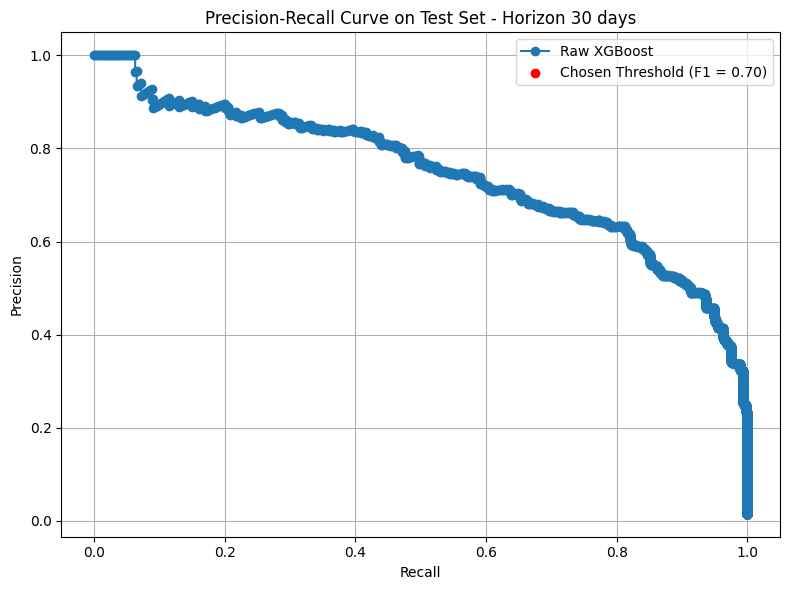

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.4355662167072296

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9951
Accuracy: 0.9900
Precision: 0.6444
Recall: 0.7664
F1 Score: 0.7001
Brier Score: 0.0067
TN: 27438, FP: 181, FN: 100, TP: 328
FNR: 0.2336, FPR: 0.0066
Specificity: 0.9934, Sensitivity: 0.7664


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.3048780560493469

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9950
Accuracy: 0.9879
Precision: 0.5705
Recall: 0.8505
F1 Score: 0.6829
Brier Score: 0.0067
TN: 27345, FP: 274, FN: 64, TP: 364
FNR: 0.1495, FPR: 0.0099
Specificity: 0.9901, Sensitivity: 0.8505


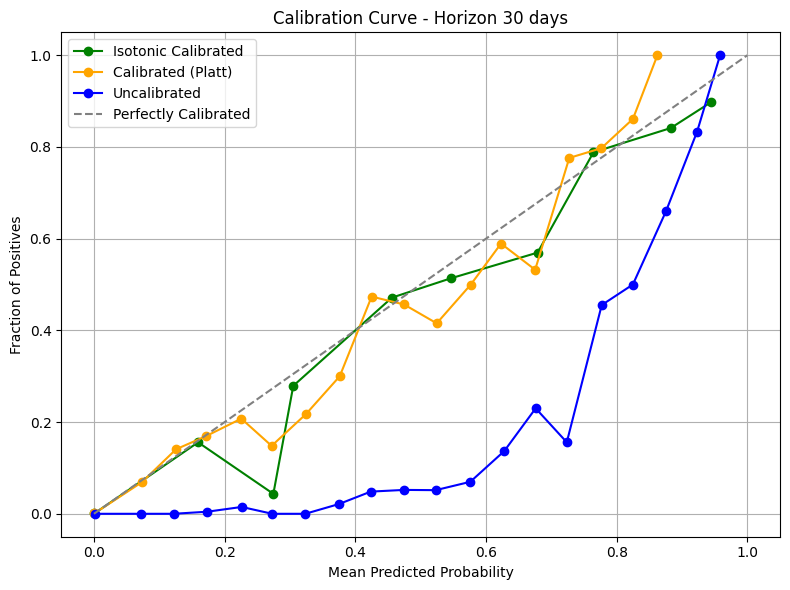

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.898
Average prediction set size: 0.90
set length 1 positives: 13, negatives: 25178, set length 2: 2856
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.976967233572218
Precision: 0.39539347408829173
Recall: 0.9626168224299065
F1 Score: 0.5605442176870749
TN: 26989, FP: 630, FN: 16, TP: 412
Specificity: 0.9772, Sensitivity: 0.9626
====== Metrics on single-label predictions (confident) ======
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
TN: 25178, FP: 0, FN: 0, TP: 13
Specificity: 1.0000, Sensitivity: 1.0000
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9889471244696403
Precision: 0.8390804597701149
Recall: 0.3411214953271028
F1 Score: 0.4850498338870432
TN: 27591, FP: 28, FN: 282, TP: 146
Specificity: 0.9990, Sensitivity: 0.3411

===== XGBoost Training for Horizon 90 days =====
Applying ADASY

c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [17:18:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.59774214
Classification report for Horizon 90 days:
               precision    recall  f1-score   support

No Graft Loss       0.99      0.98      0.98     27043
   Graft Loss       0.55      0.74      0.63      1004

     accuracy                           0.97     28047
    macro avg       0.77      0.86      0.81     28047
 weighted avg       0.97      0.97      0.97     28047

Brier Score (Raw XGBoost): 0.031019360359396727
ROC AUC (Raw XGBoost): 0.9824931314198886
Accuracy: 0.9689806396406033
Precision: 0.549264705882353
Recall: 0.7440239043824701
F1 Score: 0.631979695431472
TN: 26430, FP: 613, FN: 257, TP: 747
FNR: 0.2560, FPR: 0.0227
Specificity: 0.9773, Sensitivity: 0.7440


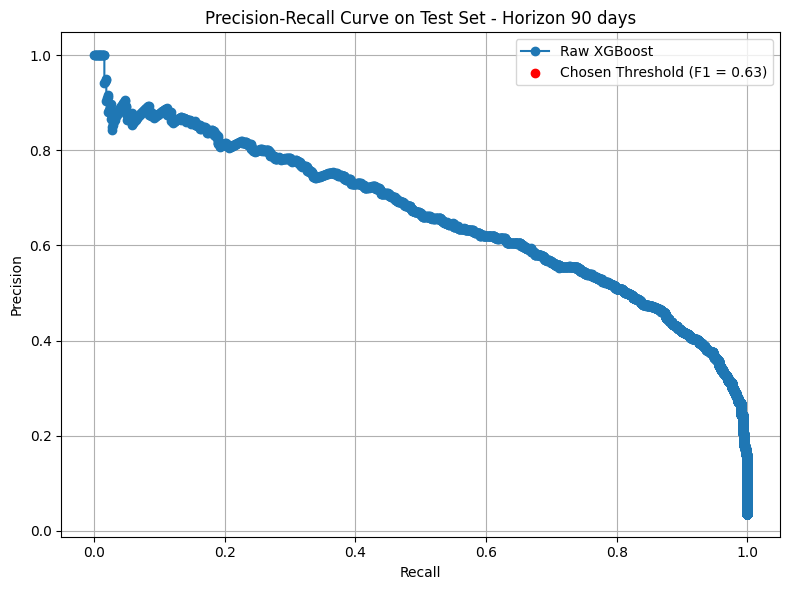

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.2878488600254059

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9825
Accuracy: 0.9690
Precision: 0.5493
Recall: 0.7440
F1 Score: 0.6320
Brier Score: 0.0186
TN: 26430, FP: 613, FN: 257, TP: 747
FNR: 0.2560, FPR: 0.0227
Specificity: 0.9773, Sensitivity: 0.7440


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.28232190012931824

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9805
Accuracy: 0.9658
Precision: 0.5141
Recall: 0.7968
F1 Score: 0.6250
Brier Score: 0.0184
TN: 26287, FP: 756, FN: 204, TP: 800
FNR: 0.2032, FPR: 0.0280
Specificity: 0.9720, Sensitivity: 0.7968


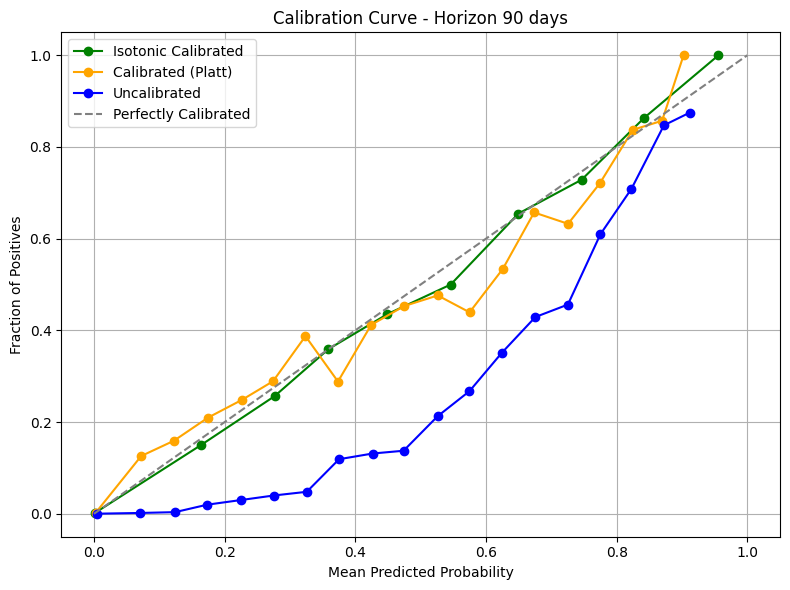

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.898
Average prediction set size: 0.90
set length 1 positives: 522, negatives: 24822, set length 2: 2703
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.960316611402289
Precision: 0.47020229633679606
Recall: 0.8565737051792829
F1 Score: 0.6071302506177197
TN: 26074, FP: 969, FN: 144, TP: 860
Specificity: 0.9642, Sensitivity: 0.8566
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9937263257575758
Precision: 0.7394636015325671
Recall: 0.9437652811735942
F1 Score: 0.8292158968850698
TN: 24799, FP: 136, FN: 23, TP: 386
Specificity: 0.9945, Sensitivity: 0.9438
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9731522087923842
Precision: 0.739961759082218
Recall: 0.3854581673306773
F1 Score: 0.5068762278978389
TN: 26907, FP: 136, FN: 617, TP: 387
Specificity: 0.9950, Sensitivity: 0.385

c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [17:19:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.5301192
Classification report for Horizon 180 days:
               precision    recall  f1-score   support

No Graft Loss       0.98      0.97      0.97     26491
   Graft Loss       0.55      0.66      0.60      1556

     accuracy                           0.95     28047
    macro avg       0.76      0.82      0.79     28047
 weighted avg       0.96      0.95      0.95     28047

Brier Score (Raw XGBoost): 0.048846578956751166
ROC AUC (Raw XGBoost): 0.9662812436954142
Accuracy: 0.9511534210432488
Precision: 0.5495735607675906
Recall: 0.6625964010282777
F1 Score: 0.6008158508158508
TN: 25646, FP: 845, FN: 525, TP: 1031
FNR: 0.3374, FPR: 0.0319
Specificity: 0.9681, Sensitivity: 0.6626


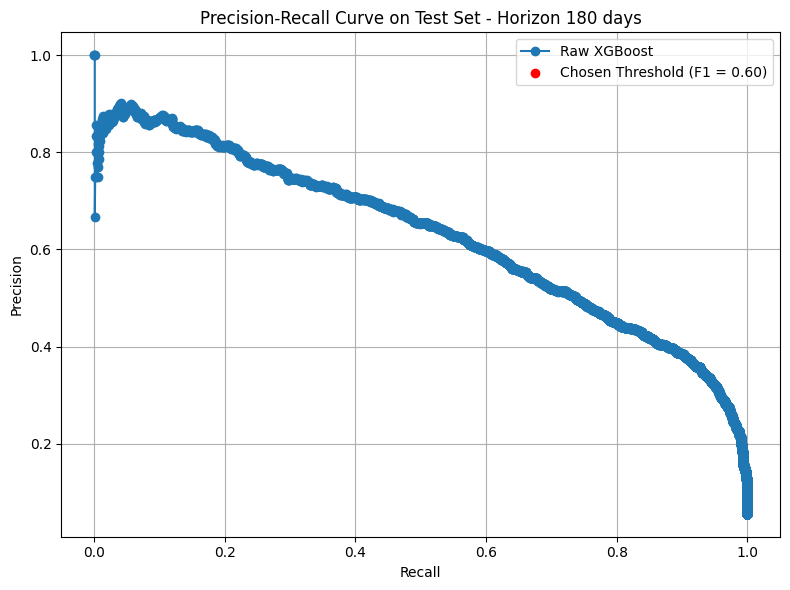

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.30751466751098633

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9663
Accuracy: 0.9512
Precision: 0.5496
Recall: 0.6626
F1 Score: 0.6008
Brier Score: 0.0305
TN: 25646, FP: 845, FN: 525, TP: 1031
FNR: 0.3374, FPR: 0.0319
Specificity: 0.9681, Sensitivity: 0.6626


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.26763486862182617

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9660
Accuracy: 0.9466
Precision: 0.5135
Recall: 0.7217
F1 Score: 0.6001
Brier Score: 0.0301
TN: 25427, FP: 1064, FN: 433, TP: 1123
FNR: 0.2783, FPR: 0.0402
Specificity: 0.9598, Sensitivity: 0.7217


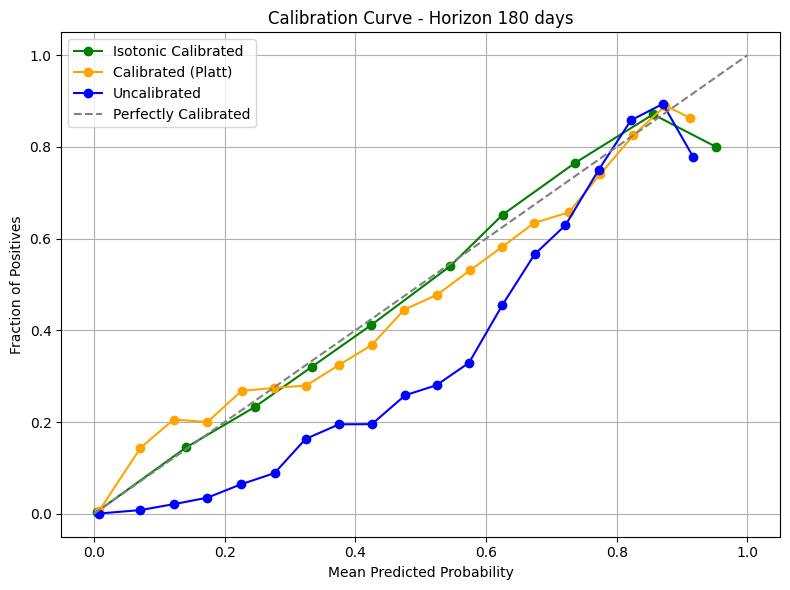

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.899
Average prediction set size: 0.92
set length 1 positives: 1005, negatives: 24754, set length 2: 2288
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9474810140121939
Precision: 0.5198850023957834
Recall: 0.6973007712082262
F1 Score: 0.5956629151797969
TN: 25489, FP: 1002, FN: 471, TP: 1085
Specificity: 0.9622, Sensitivity: 0.6973
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9793470243410071
Precision: 0.6865671641791045
Recall: 0.7607497243660419
F1 Score: 0.7217573221757322
TN: 24537, FP: 315, FN: 217, TP: 690
Specificity: 0.9873, Sensitivity: 0.7607
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9578921096730488
Precision: 0.6675603217158177
Recall: 0.4800771208226221
F1 Score: 0.5585046728971963
TN: 26119, FP: 372, FN: 809, TP: 747
Specificity: 0.9860, Sensitivity: 

c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [17:20:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.4110562
Classification report for Horizon 360 days:
               precision    recall  f1-score   support

No Graft Loss       0.97      0.94      0.96     25793
   Graft Loss       0.50      0.66      0.57      2254

     accuracy                           0.92     28047
    macro avg       0.73      0.80      0.76     28047
 weighted avg       0.93      0.92      0.92     28047

Brier Score (Raw XGBoost): 0.08043641031126324
ROC AUC (Raw XGBoost): 0.9355570668407003
Accuracy: 0.9195635896887367
Precision: 0.49966397849462363
Recall: 0.6597160603371783
F1 Score: 0.568642447418738
TN: 24304, FP: 1489, FN: 767, TP: 1487
FNR: 0.3403, FPR: 0.0577
Specificity: 0.9423, Sensitivity: 0.6597


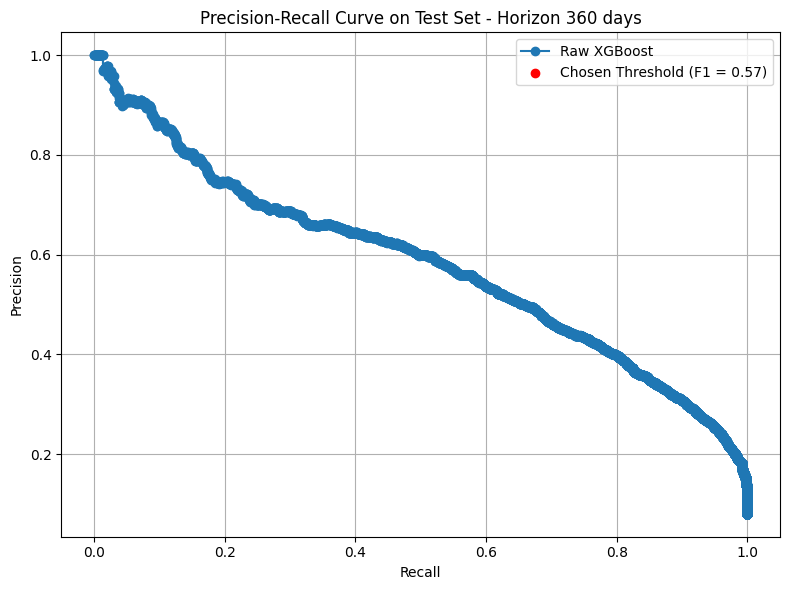

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.23046274483203888

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9356
Accuracy: 0.9196
Precision: 0.4997
Recall: 0.6597
F1 Score: 0.5686
Brier Score: 0.0482
TN: 24304, FP: 1489, FN: 767, TP: 1487
FNR: 0.3403, FPR: 0.0577
Specificity: 0.9423, Sensitivity: 0.6597


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.23483780026435852

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9355
Accuracy: 0.9058
Precision: 0.4469
Recall: 0.7232
F1 Score: 0.5524
Brier Score: 0.0475
TN: 23776, FP: 2017, FN: 624, TP: 1630
FNR: 0.2768, FPR: 0.0782
Specificity: 0.9218, Sensitivity: 0.7232


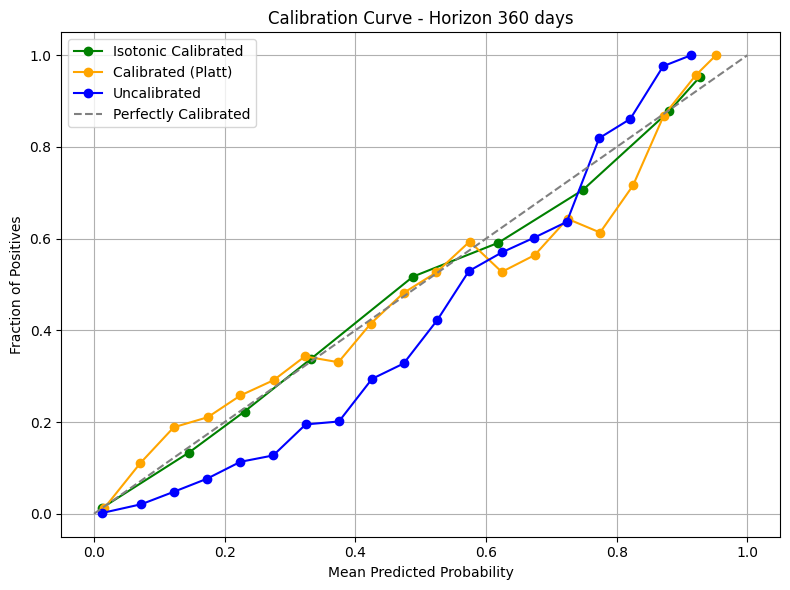

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.900
Average prediction set size: 0.95
set length 1 positives: 1351, negatives: 25178, set length 2: 1518
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.931543480586159
Precision: 0.5803657362848893
Recall: 0.5350488021295474
F1 Score: 0.556786703601108
TN: 24921, FP: 872, FN: 1048, TP: 1206
Specificity: 0.9662, Sensitivity: 0.5350
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9520147762825587
Precision: 0.6484085862324205
Recall: 0.5232974910394266
F1 Score: 0.5791735537190082
TN: 24380, FP: 475, FN: 798, TP: 876
Specificity: 0.9809, Sensitivity: 0.5233
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9338966734410097
Precision: 0.61441647597254
Recall: 0.4764862466725821
F1 Score: 0.5367316341829086
TN: 25119, FP: 674, FN: 1180, TP: 1074
Specificity: 0.9739, Sensitivity: 0.

In [ ]:
# mortality prediction
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, brier_score_loss, confusion_matrix, classification_report
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE, ADASYN
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import joblib


for H in horizons:
    event_name = f'Mortality@{H}'
    print(f"\n===== XGBoost Training for Horizon {H} days =====")
    # Convert data to tensors
    X_train = torch.tensor(train_mort_repr_p[H], dtype=torch.float32)
    y_train = torch.tensor(train_mort_lbl_p[H], dtype=torch.float32)

    # Original test set (30% of full data)
    X_test = test_mort_repr[H]
    y_test = test_mort_lbl[H]

    X_val = val_mort_repr[H]
    y_val = val_mort_lbl[H]

    up_sampling_SMOTE = False
    up_sampling_ADASYN = True

    if up_sampling_ADASYN:
        # apply ADASYN
        print("Applying ADASYN for upsampling...")
        smote = ADASYN(random_state=0, sampling_strategy=0.5)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After ADASYN: {X_train.shape}, Positives: {sum(y_train)} ({sum(y_train)/len(y_train):.4f})")
    elif up_sampling_SMOTE:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After SMOTE: {X_train.shape}, Positives: {sum(y_train)} ({sum(y_train)/len(y_train):.4f})")
    else:
        print("No upsampling applied.")

    # Train XGBoost
    xgboost_model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train) / 6,
        eval_metric=['aucpr', 'logloss'],
        objective='binary:logistic',
        random_state=0,
        max_delta_step=10,
    )
    print(f"Scale pos weight: {xgboost_model.get_params()['scale_pos_weight']:.4f}")
    xgboost_model.fit(X_train, y_train)

    # save model
    xgboost_model.save_model(f'../models/{event_name}_xgboost.pkl')

    # Tune threshold on validation set
    y_prob_val = xgboost_model.predict_proba(X_val)[:, 1]
    precision, recall, thresh = precision_recall_curve(y_val, y_prob_val)
    precision = precision[1:]
    recall = recall[1:]

    # F1
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

    # Vectorized cost computation
    y_preds = (y_prob_val[None, :] >= thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    tp = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    fp = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    fn = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    costs = fp * cost_fp + fn * cost_fn

    # Normalize
    f1_norm = f1_scores
    costs_norm = 1 - (costs - np.min(costs)) / (np.max(costs) - np.min(costs))

    # Combine
    alpha = 0.7
    beta = 0.3
    hybrid_score = alpha * f1_norm + beta * costs_norm

    optimal_threshold = thresh[np.argmax(hybrid_score)]
    print("Optimal threshold (hybrid F1 + cost):", optimal_threshold)

    # Predict on xgboost
    y_prob_raw = xgboost_model.predict_proba(X_test)[:, 1]
    y_pred_base = (y_prob_raw >= optimal_threshold).astype(int)
    print(f"Classification report for Horizon {H} days:")
    print(classification_report(y_test, y_pred_base, target_names=['No Graft Loss', 'Graft Loss']))
    print("Brier Score (Raw XGBoost):", brier_score_loss(y_test, y_pred_base))
    print("ROC AUC (Raw XGBoost):", roc_auc_score(y_test, y_prob_raw))
    print("Accuracy:", accuracy_score(y_test, y_pred_base))
    print("Precision:", precision_score(y_test, y_pred_base))
    print("Recall:", recall_score(y_test, y_pred_base))
    print("F1 Score:", f1_score(y_test, y_pred_base))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_base).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"FNR: {fn / (tp + fn):.4f}, FPR: {fp / (tn + fp):.4f}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")

    # plot PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob_raw)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o', label='Raw XGBoost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve on Test Set - Horizon {H} days')
    # Compute metrics at chosen threshold on test set
    precision_test = precision_score(y_test, y_pred_base)
    recall_test = recall_score(y_test, y_pred_base)
    plt.scatter(recall_test, precision_test, color='red', label=f'Chosen Threshold (F1 = {f1_score(y_test, y_pred_base):.2f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Apply Platt scaling (calibration)
    platt_calibrator = CalibratedClassifierCV(xgboost_model, method='sigmoid', cv='prefit')
    platt_calibrator.fit(X_val, y_val)
    y_prob_cal_val = platt_calibrator.predict_proba(X_val)[:, 1]  # Calibrated probs on validation
    y_prob_cal_test = platt_calibrator.predict_proba(X_test)[:, 1]  # Calibrated probs on test

    # save calibrated model
    joblib.dump(platt_calibrator, f'../models/{event_name}_platt.pkl')
    
    platt_precision, platt_recall, platt_thresh = precision_recall_curve(y_val, y_prob_cal_val)

    platt_precision = platt_precision[1:]
    platt_recall = platt_recall[1:]

    # F1
    platt_f1_scores = 2 * (platt_precision * platt_recall) / (platt_precision + platt_recall + 1e-10)

    # Vectorized cost computation
    y_preds = (y_prob_cal_val[None, :] >= platt_thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    tp_p = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    fp_p = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    fn_p = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    costs_p = fp_p * cost_fp + fn_p * cost_fn

    # Normalize
    platt_f1_norm = platt_f1_scores
    costs_norm_p = 1 - (costs_p - np.min(costs_p)) / (np.max(costs_p) - np.min(costs_p))

    # Combine
    alpha = 0.7
    beta = 0.3
    hybrid_score_p = alpha * platt_f1_norm + beta * costs_norm_p

    platt_optimal_threshold = platt_thresh[np.argmax(hybrid_score_p)]
    print("Optimal threshold (hybrid F1 + cost) Platt scaling:", platt_optimal_threshold)

    # Evaluate calibrated predictions
    y_pred_cal_test = (y_prob_cal_test >= platt_optimal_threshold).astype(int)
    tn_cal, fp_cal, fn_cal, tp_cal = confusion_matrix(y_test, y_pred_cal_test).ravel()
    print(f"\n[Test Set Evaluation (Platt Calibrated)]")
    print(f"AUC: {roc_auc_score(y_test, y_prob_cal_test):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_cal_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob_cal_test):.4f}")
    print(f"TN: {tn_cal}, FP: {fp_cal}, FN: {fn_cal}, TP: {tp_cal}")
    print(f"FNR: {fn_cal / (tp_cal + fn_cal):.4f}, FPR: {fp_cal / (tn_cal + fp_cal):.4f}")
    print(f"Specificity: {tn_cal / (tn_cal + fp_cal):.4f}, Sensitivity: {tp_cal / (tp_cal + fn_cal):.4f}")

    prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_cal_test, n_bins=20)
    prob_true_orig, prob_pred_orig = calibration_curve(y_test, y_prob_raw, n_bins=20)

    # Try istonic calibration
    iso_calibrator = CalibratedClassifierCV(xgboost_model, method='isotonic', cv='prefit')
    iso_calibrator.fit(X_val, y_val)
    y_prob_isotonic_cal_val = iso_calibrator.predict_proba(X_val)[:, 1]  # Calibrated probs on validation
    y_prob_isotonic_cal_test = iso_calibrator.predict_proba(X_test)[:, 1]  # Calibrated probs on test

    # save isotonic calibrated model
    joblib.dump(iso_calibrator, f'../models/{event_name}_iso.pkl')
    
    iso_precision, iso_recall, iso_thresh = precision_recall_curve(y_val, y_prob_isotonic_cal_val)

    iso_precision = iso_precision[1:]
    iso_recall = iso_recall[1:]

    # F1
    iso_f1_scores = 2 * (iso_precision * iso_recall) / (iso_precision + iso_recall + 1e-10)

    # Vectorized cost computation
    y_preds = (y_prob_isotonic_cal_val[None, :] >= iso_thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    iso_tp = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    iso_fp = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    iso_fn = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    iso_costs = iso_fp * cost_fp + iso_fn * cost_fn

    # Normalize
    iso_f1_norm = iso_f1_scores
    iso_costs_norm = 1 - (iso_costs - np.min(iso_costs)) / (np.max(iso_costs) - np.min(iso_costs))

    # Combine
    alpha = 0.7
    beta = 0.3
    iso_hybrid_score = alpha * iso_f1_norm + beta * iso_costs_norm

    iso_optimal_threshold = iso_thresh[np.argmax(iso_hybrid_score)]
    print("Optimal threshold (hybrid F1 + cost) Isotonic:", iso_optimal_threshold)

    y_pred_isotonic_cal_test = (y_prob_isotonic_cal_test >= iso_optimal_threshold).astype(int)
    tn_iso, fp_iso, fn_iso, tp_iso = confusion_matrix(y_test, y_pred_isotonic_cal_test).ravel()
    print(f"\n[Test Set Evaluation (Isotonic Calibrated)]")
    print(f"AUC: {roc_auc_score(y_test, y_prob_isotonic_cal_test):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_isotonic_cal_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob_isotonic_cal_test):.4f}")
    print(f"TN: {tn_iso}, FP: {fp_iso}, FN: {fn_iso}, TP: {tp_iso}")
    print(f"FNR: {fn_iso / (tp_iso + fn_iso):.4f}, FPR: {fp_iso / (tn_iso + fp_iso):.4f}")
    print(f"Specificity: {tn_iso / (tn_iso + fp_iso):.4f}, Sensitivity: {tp_iso / (tp_iso + fn_iso):.4f}")
    # Plot calibration curve for isotonic regression
    plt.figure(figsize=(8, 6))
    prob_true_iso, prob_pred_iso = calibration_curve(y_test, y_prob_isotonic_cal_test, n_bins=10)
    plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='Isotonic Calibrated', color='green')
    plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated (Platt)', color='orange')
    plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='Uncalibrated', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve - Horizon {H} days')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    threshold_data = {
        'xgboost_threshold': float(optimal_threshold),
        'platt_threshold': float(platt_optimal_threshold),
        'iso_threshold': float(iso_optimal_threshold)
    }
    # Save thresholds as a JSON file
    with open(f'../models/{event_name}_thresholds.json', 'w') as f:
        json.dump(threshold_data, f, indent=4)


    print("Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...")
    mapie_clf = MapieClassifier(estimator=xgboost_model, cv="prefit", method="lac")
    mapie_clf.fit(X_val, y_val)
    y_pred, y_psets = mapie_clf.predict(X_test, alpha=0.1)
    y_psets = y_psets[:, :, 0]
    y_test = np.array(y_test).astype(int)
    coverage = classification_coverage_score(y_test, y_psets)
    print(f"Prediction set coverage (expected ~0.9): {coverage:.3f}")
    avg_set_size = np.mean(np.sum(y_psets, axis=1))
    print(f"Average prediction set size: {avg_set_size:.2f}")
    set_1_p = 0
    set_1_n = 0
    set_2 = 0

    for i in range(len(y_test)):
        pred_set = y_psets[i]
        labels_in_set = np.where(pred_set)[0]
        if len(labels_in_set) == 1:
            if labels_in_set[0] == 1:
                set_1_p += 1
            else:
                set_1_n += 1
        else:
            set_2 += 1
        
    print(f"set length 1 positives: {set_1_p}, negatives: {set_1_n}, set length 2: {set_2}")

    is_singleton = np.sum(y_psets, axis=1) == 1
    y_pred_filtered = y_pred[is_singleton]
    y_true_filtered = y_test[is_singleton]

    # Metrics for default y_pred
    print("====== Metrics on single-label predictions (confident + ambigous (default))=======")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")

    print("====== Metrics on single-label predictions (confident) ======")
    print("Accuracy:", accuracy_score(y_true_filtered, y_pred_filtered))
    print("Precision:", precision_score(y_true_filtered, y_pred_filtered))
    print("Recall:", recall_score(y_true_filtered, y_pred_filtered))
    print("F1 Score:", f1_score(y_true_filtered, y_pred_filtered))
    tn, fp, fn, tp = confusion_matrix(y_true_filtered, y_pred_filtered).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")

    # Find singleton vs ambiguous predictions
    singleton_mask = np.sum(y_psets, axis=1) == 1

    # Use calibrated model to predict probabilities for uncertain samples
    y_pred_isotonic_cal_test = (y_prob_isotonic_cal_test >= optimal_threshold).astype(int)

    # Combine predictions
    final_preds = np.copy(y_pred)
    final_preds[~singleton_mask] = y_pred_isotonic_cal_test[~singleton_mask]

    # Evaluate
    print("====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======")
    print("Accuracy:", accuracy_score(y_test, final_preds))
    print("Precision:", precision_score(y_test, final_preds))
    print("Recall:", recall_score(y_test, final_preds))
    print("F1 Score:", f1_score(y_test, final_preds))
    tn, fp, fn, tp = confusion_matrix(y_test, final_preds).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")


In [ ]:
# construct undersampled training set for rejection + validation set construction
# Initialize dictionaries with same structure but with _p suffix
train_rej_repr_p = {H: None for H in horizons}
test_rej_repr_p = {H: None for H in horizons}
train_rej_lbl_p = {H: None for H in horizons}
test_rej_lbl_p = {H: None for H in horizons}

undersample_ratio = 0.4  # Ratio of negative to positive samples in the undersampled dataset
random_state = 42  # For reproducibility

# Print stats and process each dataset for all horizons
for H in horizons:
    print(f"\n===== Original Extracted Features for Horizon {H} days =====")
    print(f"Rejection Training: {train_rej_repr[H].shape}, Positive: {sum(train_rej_lbl[H])}, Ratio: {sum(train_rej_lbl[H])/len(train_rej_lbl[H]):.4f}")
    print(f"Rejecton Testing: {test_rej_repr[H].shape}, Positive: {sum(test_rej_lbl[H])}, Ratio: {sum(test_rej_lbl[H])/len(test_rej_lbl[H]):.4f}")
    
    # Process graft loss data
    print(f"\n--- Processing Rejection data for horizon {H} ---")
    # Combine train and test to get a full dataset before new stratified split
    X_rej = np.vstack((train_rej_repr[H], test_rej_repr[H]))
    y_rej = np.concatenate((train_rej_lbl[H], test_rej_lbl[H]))
    
    # Get the indices of negative and positive samples
    neg_indices = np.where(y_rej == 0)[0]
    pos_indices = np.where(y_rej == 1)[0]
    
    # Randomly select subset of negative samples
    np.random.seed(random_state)
    neg_indices_subset = np.random.choice(neg_indices, size=int(undersample_ratio * len(neg_indices)), replace=False)
    
    # Combine with all positive samples
    selected_indices = np.concatenate([neg_indices_subset, pos_indices])
    
    # Create the balanced subset
    X_subset = X_rej[selected_indices]
    y_subset = y_rej[selected_indices]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y_subset, 
        test_size=test_size, 
        stratify=y_subset,
        random_state=random_state
    )
    
    # Store processed data with _p suffix
    train_rej_repr_p[H] = X_train
    test_rej_repr_p[H] = X_test
    train_rej_lbl_p[H] = y_train
    test_rej_lbl_p[H] = y_test
    
    print(f"Undersampled Rejection:")
    print(f"Train: {len(train_rej_lbl_p[H])} samples, {sum(train_rej_lbl_p[H])} positives ({sum(train_rej_lbl_p[H])/len(train_rej_lbl_p[H]):.4f})")
    print(f"Test: {len(test_rej_lbl_p[H])} samples, {sum(test_rej_lbl_p[H])} positives ({sum(test_rej_lbl_p[H])/len(test_rej_lbl_p[H]):.4f})")

# construct validation set Rejection
val_rej_repr = {H: None for H in horizons}
val_rej_lbl = {H: None for H in horizons}

for H in horizons:
    # Step 1: Original test set (30% of full data)
    X_test_full = torch.tensor(test_rej_repr[H], dtype=torch.float32)
    y_test_full = torch.tensor(test_rej_lbl[H], dtype=torch.float32)

    # Step 2: Split 2/3 for validation (20%) and 1/3 for final test (10%)
    val_rej_repr[H], test_rej_repr[H], val_rej_lbl[H], test_rej_lbl[H] = train_test_split(
        X_test_full, y_test_full,
        test_size=1/3,  # 10% out of 30% = 1/3
        stratify=y_test_full,
        random_state=42
    )

# Print validation set stats
for H in horizons:
    print(f"\nValidation set for Horizon {H} days:")
    print(f"Samples: {len(val_rej_lbl[H])}, Positives: {sum(val_rej_lbl[H])} ({sum(val_rej_lbl[H])/len(val_rej_lbl[H]):.4f})")
    print(f"Test set for Horizon {H} days:")
    print(f"Samples: {len(test_rej_lbl[H])}, Positives: {sum(test_rej_lbl[H])} ({sum(test_rej_lbl[H])/len(test_rej_lbl[H]):.4f})")


===== Original Extracted Features for Horizon 30 days =====
Rejection Training: (190449, 512), Positive: 1151, Ratio: 0.0060
Rejecton Testing: (82456, 512), Positive: 495, Ratio: 0.0060

--- Processing Rejection data for horizon 30 ---
Undersampled Rejection:
Train: 109218 samples, 1632 positives (0.0149)
Test: 931 samples, 14 positives (0.0150)

===== Original Extracted Features for Horizon 90 days =====
Rejection Training: (190449, 512), Positive: 1929, Ratio: 0.0101
Rejecton Testing: (82456, 512), Positive: 645, Ratio: 0.0078

--- Processing Rejection data for horizon 90 ---
Undersampled Rejection:
Train: 109775 samples, 2552 positives (0.0232)
Test: 931 samples, 22 positives (0.0236)

===== Original Extracted Features for Horizon 180 days =====
Rejection Training: (190449, 512), Positive: 2414, Ratio: 0.0127
Rejecton Testing: (82456, 512), Positive: 835, Ratio: 0.0101

--- Processing Rejection data for horizon 180 ---
Undersampled Rejection:
Train: 110180 samples, 3222 positives (


===== XGBoost Training for Horizon 30 days =====
Applying ADASYN for upsampling...
After ADASYN: (215110, 512), Positives: 107524.0 (0.4999)
Scale pos weight: 1.0006


c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [11:13:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.89843506
Classification report for Horizon 30 days:
               precision    recall  f1-score   support

No Graft Loss       1.00      1.00      1.00     27321
   Graft Loss       0.42      0.55      0.47       165

     accuracy                           0.99     27486
    macro avg       0.71      0.77      0.73     27486
 weighted avg       0.99      0.99      0.99     27486

Brier Score (Raw XGBoost): 0.007312813796114386
ROC AUC (Raw XGBoost): 0.9928388973738704
Accuracy: 0.9926871862038856
Precision: 0.4166666666666667
Recall: 0.5454545454545454
F1 Score: 0.47244094488188976
TN: 27195, FP: 126, FN: 75, TP: 90
FNR: 0.4545, FPR: 0.0046
Specificity: 0.9954, Sensitivity: 0.5455


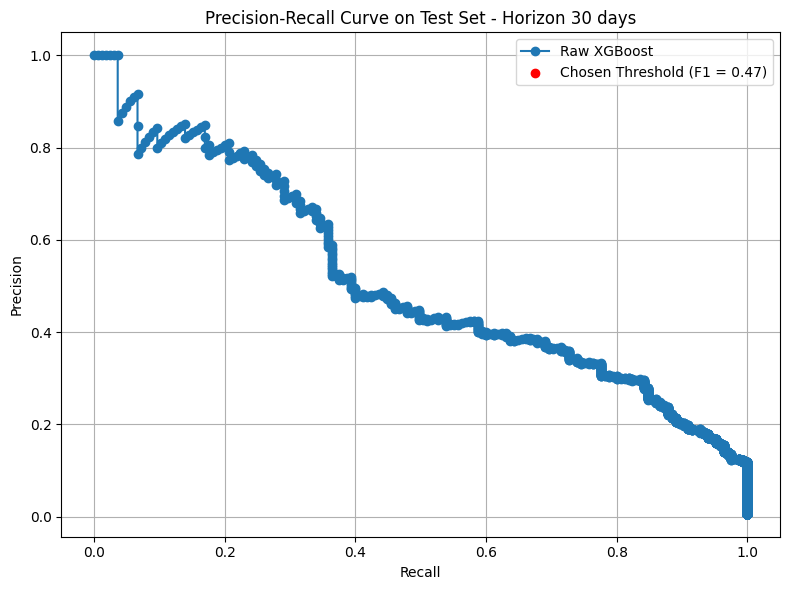

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.274798721075058

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9928
Accuracy: 0.9927
Precision: 0.4167
Recall: 0.5455
F1 Score: 0.4724
Brier Score: 0.0041
TN: 27195, FP: 126, FN: 75, TP: 90
FNR: 0.4545, FPR: 0.0046
Specificity: 0.9954, Sensitivity: 0.5455


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.22580644488334656

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9928
Accuracy: 0.9919
Precision: 0.3925
Recall: 0.6303
F1 Score: 0.4837
Brier Score: 0.0040
TN: 27160, FP: 161, FN: 61, TP: 104
FNR: 0.3697, FPR: 0.0059
Specificity: 0.9941, Sensitivity: 0.6303


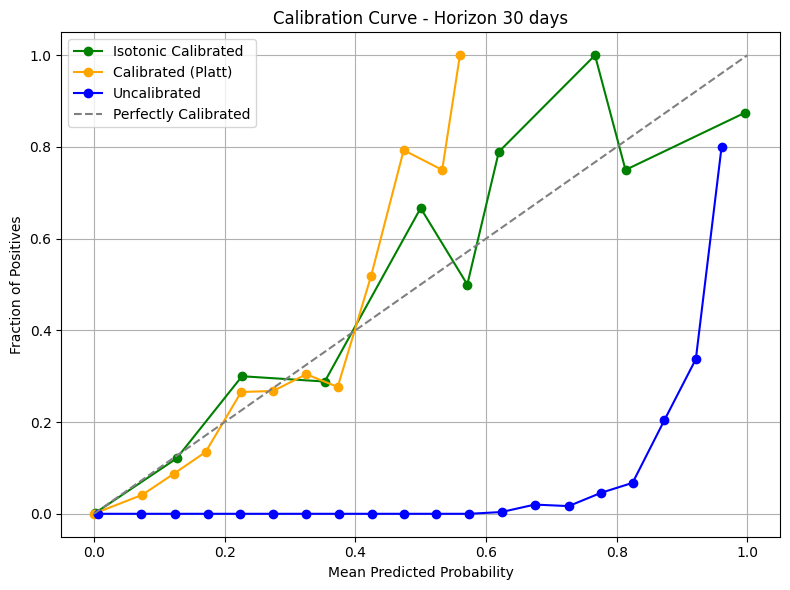


===== XGBoost Training for Horizon 90 days =====
Applying ADASYN for upsampling...
After ADASYN: (214564, 512), Positives: 107341.0 (0.5003)
Scale pos weight: 0.9989


c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [11:14:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.8712669
Classification report for Horizon 90 days:
               precision    recall  f1-score   support

No Graft Loss       1.00      0.99      0.99     27271
   Graft Loss       0.35      0.47      0.40       215

     accuracy                           0.99     27486
    macro avg       0.67      0.73      0.70     27486
 weighted avg       0.99      0.99      0.99     27486

Brier Score (Raw XGBoost): 0.010914647456887142
ROC AUC (Raw XGBoost): 0.9798854392561142
Accuracy: 0.9890853525431128
Precision: 0.35294117647058826
Recall: 0.4744186046511628
F1 Score: 0.40476190476190477
TN: 27084, FP: 187, FN: 113, TP: 102
FNR: 0.5256, FPR: 0.0069
Specificity: 0.9931, Sensitivity: 0.4744


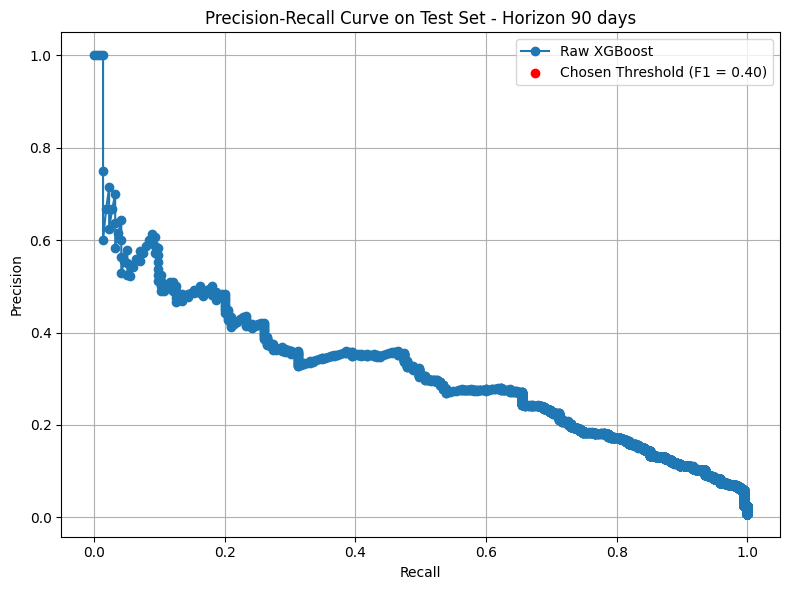

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.2168271243572235

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9799
Accuracy: 0.9891
Precision: 0.3529
Recall: 0.4744
F1 Score: 0.4048
Brier Score: 0.0062
TN: 27084, FP: 187, FN: 113, TP: 102
FNR: 0.5256, FPR: 0.0069
Specificity: 0.9931, Sensitivity: 0.4744


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.1666666716337204

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9783
Accuracy: 0.9849
Precision: 0.2748
Recall: 0.5674
F1 Score: 0.3703
Brier Score: 0.0062
TN: 26949, FP: 322, FN: 93, TP: 122
FNR: 0.4326, FPR: 0.0118
Specificity: 0.9882, Sensitivity: 0.5674


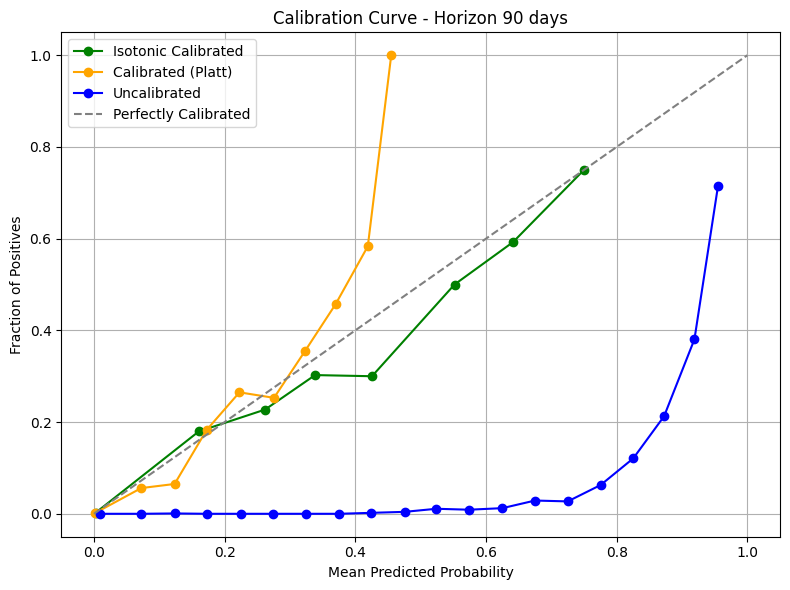


===== XGBoost Training for Horizon 180 days =====
Applying ADASYN for upsampling...
After ADASYN: (213546, 512), Positives: 106588.0 (0.4991)
Scale pos weight: 1.0035


c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [11:16:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.83439916
Classification report for Horizon 180 days:
               precision    recall  f1-score   support

No Graft Loss       0.99      0.99      0.99     27208
   Graft Loss       0.25      0.45      0.32       278

     accuracy                           0.98     27486
    macro avg       0.62      0.72      0.65     27486
 weighted avg       0.99      0.98      0.98     27486

Brier Score (Raw XGBoost): 0.019428072473259114
ROC AUC (Raw XGBoost): 0.9671104192799832
Accuracy: 0.9805719275267409
Precision: 0.24603174603174602
Recall: 0.4460431654676259
F1 Score: 0.3171355498721228
TN: 26828, FP: 380, FN: 154, TP: 124
FNR: 0.5540, FPR: 0.0140
Specificity: 0.9860, Sensitivity: 0.4460


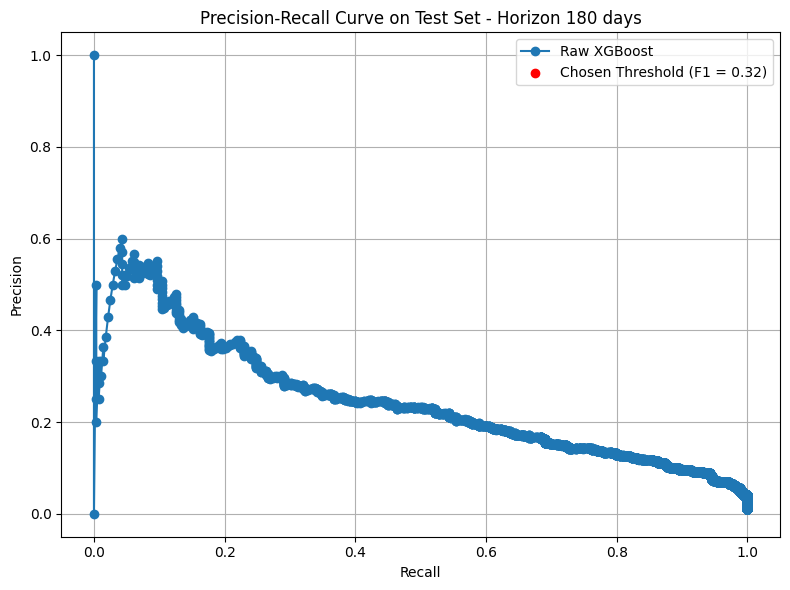

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.16644875705242157

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9671
Accuracy: 0.9806
Precision: 0.2460
Recall: 0.4460
F1 Score: 0.3171
Brier Score: 0.0085
TN: 26828, FP: 380, FN: 154, TP: 124
FNR: 0.5540, FPR: 0.0140
Specificity: 0.9860, Sensitivity: 0.4460


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.1167047992348671

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9662
Accuracy: 0.9750
Precision: 0.2124
Recall: 0.5432
F1 Score: 0.3054
Brier Score: 0.0085
TN: 26648, FP: 560, FN: 127, TP: 151
FNR: 0.4568, FPR: 0.0206
Specificity: 0.9794, Sensitivity: 0.5432


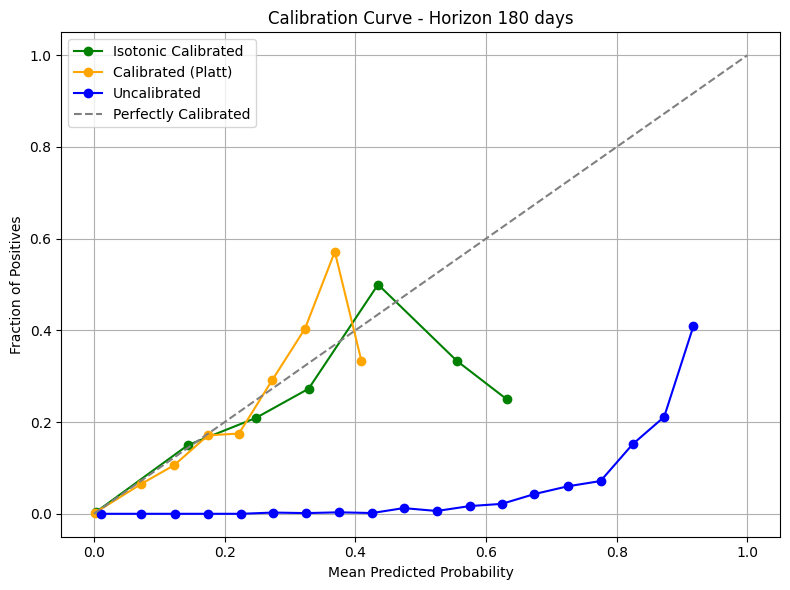


===== XGBoost Training for Horizon 360 days =====
Applying ADASYN for upsampling...
After ADASYN: (213127, 512), Positives: 106397.0 (0.4992)
Scale pos weight: 1.0031


c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [11:17:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.80545634
Classification report for Horizon 360 days:
               precision    recall  f1-score   support

No Graft Loss       0.99      0.98      0.98     27160
   Graft Loss       0.21      0.52      0.30       326

     accuracy                           0.97     27486
    macro avg       0.60      0.75      0.64     27486
 weighted avg       0.98      0.97      0.98     27486

Brier Score (Raw XGBoost): 0.02961507676635378
ROC AUC (Raw XGBoost): 0.9606283374142776
Accuracy: 0.9703849232336462
Precision: 0.20602409638554217
Recall: 0.5245398773006135
F1 Score: 0.2958477508650519
TN: 26501, FP: 659, FN: 155, TP: 171
FNR: 0.4755, FPR: 0.0243
Specificity: 0.9757, Sensitivity: 0.5245


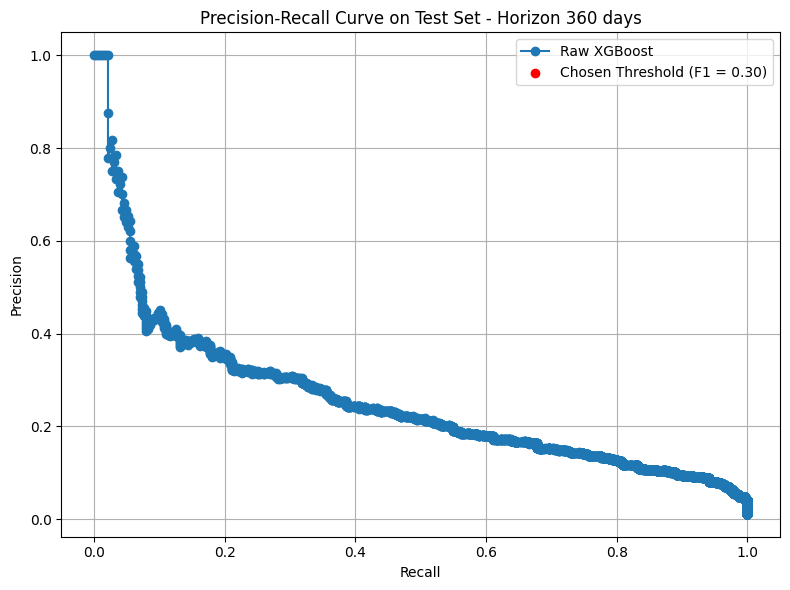

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.13717041909694672

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9606
Accuracy: 0.9704
Precision: 0.2060
Recall: 0.5245
F1 Score: 0.2958
Brier Score: 0.0100
TN: 26501, FP: 659, FN: 155, TP: 171
FNR: 0.4755, FPR: 0.0243
Specificity: 0.9757, Sensitivity: 0.5245


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.1428571492433548

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9603
Accuracy: 0.9680
Precision: 0.1963
Recall: 0.5491
F1 Score: 0.2892
Brier Score: 0.0100
TN: 26427, FP: 733, FN: 147, TP: 179
FNR: 0.4509, FPR: 0.0270
Specificity: 0.9730, Sensitivity: 0.5491


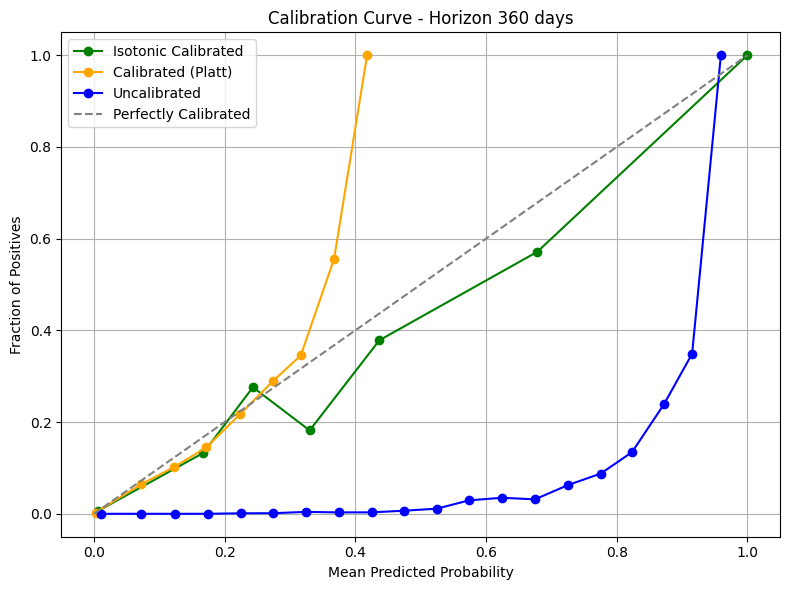

In [ ]:
# rejection prediction
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, brier_score_loss, confusion_matrix, classification_report
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE, ADASYN
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import joblib


for H in horizons:
    event_name = f'Rejection@{H}'
    print(f"\n===== XGBoost Training for Horizon {H} days =====")

    X_train = torch.tensor(train_rej_repr_p[H], dtype=torch.float32)
    y_train = torch.tensor(train_rej_lbl_p[H], dtype=torch.float32)

    # Step 1: Original test set (30% of full data)
    X_test = test_rej_repr[H]
    y_test = test_rej_lbl[H]

    X_val = val_rej_repr[H]
    y_val = val_rej_lbl[H]

    up_sampling_SMOTE = False
    up_sampling_ADASYN = True

    if up_sampling_ADASYN:
        # apply ADASYN
        print("Applying ADASYN for upsampling...")
        smote = ADASYN(random_state=0, sampling_strategy=1)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After ADASYN: {X_train.shape}, Positives: {sum(y_train)} ({sum(y_train)/len(y_train):.4f})")
    elif up_sampling_SMOTE:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After SMOTE: {X_train.shape}, Positives: {sum(y_train)} ({sum(y_train)/len(y_train):.4f})")
    else:
        print("No upsampling applied.")

    # Train XGBoost
    xgboost_model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
        eval_metric=['aucpr', 'logloss'],
        objective='binary:logistic',
        random_state=0,
        max_delta_step=10,
    )
    print(f"Scale pos weight: {xgboost_model.get_params()['scale_pos_weight']:.4f}")
    xgboost_model.fit(X_train, y_train)

    # save model
    xgboost_model.save_model(f'../models/{event_name}_xgboost.pkl')

    # Tune threshold on validation set
    y_prob_val = xgboost_model.predict_proba(X_val)[:, 1]
    precision, recall, thresh = precision_recall_curve(y_val, y_prob_val)
    precision = precision[1:]
    recall = recall[1:]

    # F1
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

    # Vectorized cost computation
    y_preds = (y_prob_val[None, :] >= thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    tp = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    fp = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    fn = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    costs = fp * cost_fp + fn * cost_fn

    # Normalize
    f1_norm = f1_scores
    costs_norm = 1 - (costs - np.min(costs)) / (np.max(costs) - np.min(costs))

    # Combine
    alpha = 0.7
    beta = 0.3
    hybrid_score = alpha * f1_norm + beta * costs_norm

    optimal_threshold = thresh[np.argmax(hybrid_score)]
    print("Optimal threshold (hybrid F1 + cost):", optimal_threshold)

    # Predict on xgboost
    y_prob_raw = xgboost_model.predict_proba(X_test)[:, 1]
    y_pred_base = (y_prob_raw >= optimal_threshold).astype(int)
    print(f"Classification report for Horizon {H} days:")
    print(classification_report(y_test, y_pred_base, target_names=['No Graft Loss', 'Graft Loss']))
    print("Brier Score (Raw XGBoost):", brier_score_loss(y_test, y_pred_base))
    print("ROC AUC (Raw XGBoost):", roc_auc_score(y_test, y_prob_raw))
    print("Accuracy:", accuracy_score(y_test, y_pred_base))
    print("Precision:", precision_score(y_test, y_pred_base))
    print("Recall:", recall_score(y_test, y_pred_base))
    print("F1 Score:", f1_score(y_test, y_pred_base))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_base).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"FNR: {fn / (tp + fn):.4f}, FPR: {fp / (tn + fp):.4f}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")

    # plot PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob_raw)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o', label='Raw XGBoost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve on Test Set - Horizon {H} days')
    # Compute metrics at chosen threshold on test set
    precision_test = precision_score(y_test, y_pred_base)
    recall_test = recall_score(y_test, y_pred_base)
    plt.scatter(recall_test, precision_test, color='red', label=f'Chosen Threshold (F1 = {f1_score(y_test, y_pred_base):.2f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Apply Platt scaling (calibration)
    platt_calibrator = CalibratedClassifierCV(xgboost_model, method='sigmoid', cv='prefit')
    platt_calibrator.fit(X_val, y_val)
    y_prob_cal_val = platt_calibrator.predict_proba(X_val)[:, 1]  # Calibrated probs on validation
    y_prob_cal_test = platt_calibrator.predict_proba(X_test)[:, 1]  # Calibrated probs on test

    # save calibrated model
    joblib.dump(platt_calibrator, f'../models/{event_name}_platt.pkl')

    # Debug: Check calibrated probability distribution
    #print(f"Calibrated Probabilities (Test) - Min: {np.min(y_prob_cal_test):.4f}, Max: {np.max(y_prob_cal_test):.4f}")
    #print(f"Calibrated Probabilities (Test) - Histogram: {np.histogram(y_prob_cal_test, bins=10)[0]}")
    
    platt_precision, platt_recall, platt_thresh = precision_recall_curve(y_val, y_prob_cal_val)

    platt_precision = platt_precision[1:]
    platt_recall = platt_recall[1:]

    # F1
    platt_f1_scores = 2 * (platt_precision * platt_recall) / (platt_precision + platt_recall + 1e-10)  # Avoid division by zero

    # Vectorized cost computation
    y_preds = (y_prob_cal_val[None, :] >= platt_thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    tp_p = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    fp_p = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    fn_p = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    costs_p = fp_p * cost_fp + fn_p * cost_fn

    # Normalize
    platt_f1_norm = platt_f1_scores
    costs_norm_p = 1 - (costs_p - np.min(costs_p)) / (np.max(costs_p) - np.min(costs_p))

    # Combine
    alpha = 0.7
    beta = 0.3
    hybrid_score_p = alpha * platt_f1_norm + beta * costs_norm_p

    platt_optimal_threshold = platt_thresh[np.argmax(hybrid_score_p)]
    print("Optimal threshold (hybrid F1 + cost) Platt scaling:", platt_optimal_threshold)

    # Evaluate calibrated predictions
    y_pred_cal_test = (y_prob_cal_test >= platt_optimal_threshold).astype(int)
    tn_cal, fp_cal, fn_cal, tp_cal = confusion_matrix(y_test, y_pred_cal_test).ravel()
    print(f"\n[Test Set Evaluation (Platt Calibrated)]")
    print(f"AUC: {roc_auc_score(y_test, y_prob_cal_test):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_cal_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob_cal_test):.4f}")
    print(f"TN: {tn_cal}, FP: {fp_cal}, FN: {fn_cal}, TP: {tp_cal}")
    print(f"FNR: {fn_cal / (tp_cal + fn_cal):.4f}, FPR: {fp_cal / (tn_cal + fp_cal):.4f}")
    print(f"Specificity: {tn_cal / (tn_cal + fp_cal):.4f}, Sensitivity: {tp_cal / (tp_cal + fn_cal):.4f}")

    prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_cal_test, n_bins=20)
    prob_true_orig, prob_pred_orig = calibration_curve(y_test, y_prob_raw, n_bins=20)

    # Try istonic calibration
    iso_calibrator = CalibratedClassifierCV(xgboost_model, method='isotonic', cv='prefit')
    iso_calibrator.fit(X_val, y_val)
    y_prob_isotonic_cal_val = iso_calibrator.predict_proba(X_val)[:, 1]  # Calibrated probs on validation
    y_prob_isotonic_cal_test = iso_calibrator.predict_proba(X_test)[:, 1]  # Calibrated probs on test

    # save isotonic calibrated model
    joblib.dump(iso_calibrator, f'../models/{event_name}_iso.pkl')
    
    iso_precision, iso_recall, iso_thresh = precision_recall_curve(y_val, y_prob_isotonic_cal_val)

    iso_precision = iso_precision[1:]
    iso_recall = iso_recall[1:]

    # F1
    iso_f1_scores = 2 * (iso_precision * iso_recall) / (iso_precision + iso_recall + 1e-10)

    # Vectorized cost computation
    y_preds = (y_prob_isotonic_cal_val[None, :] >= iso_thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    iso_tp = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    iso_fp = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    iso_fn = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    iso_costs = iso_fp * cost_fp + iso_fn * cost_fn

    # Normalize
    iso_f1_norm = iso_f1_scores
    iso_costs_norm = 1 - (iso_costs - np.min(iso_costs)) / (np.max(iso_costs) - np.min(iso_costs))

    # Combine
    alpha = 0.7
    beta = 0.3
    iso_hybrid_score = alpha * iso_f1_norm + beta * iso_costs_norm

    iso_optimal_threshold = iso_thresh[np.argmax(iso_hybrid_score)]
    print("Optimal threshold (hybrid F1 + cost) Isotonic:", iso_optimal_threshold)

    y_pred_isotonic_cal_test = (y_prob_isotonic_cal_test >= iso_optimal_threshold).astype(int)
    tn_iso, fp_iso, fn_iso, tp_iso = confusion_matrix(y_test, y_pred_isotonic_cal_test).ravel()
    print(f"\n[Test Set Evaluation (Isotonic Calibrated)]")
    print(f"AUC: {roc_auc_score(y_test, y_prob_isotonic_cal_test):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_isotonic_cal_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob_isotonic_cal_test):.4f}")
    print(f"TN: {tn_iso}, FP: {fp_iso}, FN: {fn_iso}, TP: {tp_iso}")
    print(f"FNR: {fn_iso / (tp_iso + fn_iso):.4f}, FPR: {fp_iso / (tn_iso + fp_iso):.4f}")
    print(f"Specificity: {tn_iso / (tn_iso + fp_iso):.4f}, Sensitivity: {tp_iso / (tp_iso + fn_iso):.4f}")
    # Plot calibration curve for isotonic regression
    plt.figure(figsize=(8, 6))
    prob_true_iso, prob_pred_iso = calibration_curve(y_test, y_prob_isotonic_cal_test, n_bins=10)
    plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='Isotonic Calibrated', color='green')
    plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated (Platt)', color='orange')
    plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='Uncalibrated', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve - Horizon {H} days')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    threshold_data = {
        'xgboost_threshold': float(optimal_threshold),
        'platt_threshold': float(platt_optimal_threshold),
        'iso_threshold': float(iso_optimal_threshold)
    }
    # Save thresholds as a JSON file
    with open(f'../models/{event_name}_thresholds.json', 'w') as f:
        json.dump(threshold_data, f, indent=4)


In [ ]:
# construct undersampled training sets for graft loss + validation construction
# Initialize dictionaries with same structure but with _p suffix
train_graft_repr_p = {H: None for H in horizons}
test_graft_repr_p = {H: None for H in horizons}
train_graft_lbl_p = {H: None for H in horizons}
test_graft_lbl_p = {H: None for H in horizons}

undersample_ratio = 0.4  # Ratio of negative to positive samples in the undersampled dataset
random_state = 42  # For reproducibility

# Print stats and process each dataset for all horizons
for H in horizons:
    print(f"\n===== Original Extracted Features for Horizon {H} days =====")
    print(f"Graft Loss Training: {train_graft_repr[H].shape}, Positive: {sum(train_graft_lbl[H])}, Ratio: {sum(train_graft_lbl[H])/len(train_graft_lbl[H]):.4f}")
    print(f"Graft Loss Testing: {test_graft_repr[H].shape}, Positive: {sum(test_graft_lbl[H])}, Ratio: {sum(test_graft_lbl[H])/len(test_graft_lbl[H]):.4f}")
    
    # Process graft loss data
    print(f"\n--- Processing Graft Loss data for horizon {H} ---")
    # Combine train and test to get a full dataset before new stratified split
    X_graft = np.vstack((train_graft_repr[H], test_graft_repr[H]))
    y_graft = np.concatenate((train_graft_lbl[H], test_graft_lbl[H]))
    
    # Get the indices of negative and positive samples
    neg_indices = np.where(y_graft == 0)[0]
    pos_indices = np.where(y_graft == 1)[0]
    
    # Randomly select subset of negative samples
    np.random.seed(random_state)
    neg_indices_subset = np.random.choice(neg_indices, size=int(undersample_ratio * len(neg_indices)), replace=False)
    
    # Combine with all positive samples
    selected_indices = np.concatenate([neg_indices_subset, pos_indices])
    
    # Create the balanced subset
    X_subset = X_graft[selected_indices]
    y_subset = y_graft[selected_indices]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y_subset, 
        test_size=test_size, 
        stratify=y_subset,
        random_state=random_state
    )
    
    # Store processed data with _p suffix
    train_graft_repr_p[H] = X_train
    test_graft_repr_p[H] = X_test
    train_graft_lbl_p[H] = y_train
    test_graft_lbl_p[H] = y_test
    
    print(f"Undersampled Graft Loss:")
    print(f"Train: {len(train_graft_lbl_p[H])} samples, {sum(train_graft_lbl_p[H])} positives ({sum(train_graft_lbl_p[H])/len(train_graft_lbl_p[H]):.4f})")
    print(f"Test: {len(test_graft_lbl_p[H])} samples, {sum(test_graft_lbl_p[H])} positives ({sum(test_graft_lbl_p[H])/len(test_graft_lbl_p[H]):.4f})")

# construct validation set graft loss
val_graft_repr = {H: None for H in horizons}
val_graft_lbl = {H: None for H in horizons}

for H in horizons:
    # Original test set (30% of full data)
    X_test_full = torch.tensor(test_graft_repr[H], dtype=torch.float32)
    y_test_full = torch.tensor(test_graft_lbl[H], dtype=torch.float32)

    # Split 2/3 for validation (20%) and 1/3 for final test (10%)
    val_graft_repr[H], test_graft_repr[H], val_graft_lbl[H], test_graft_lbl[H] = train_test_split(
        X_test_full, y_test_full,
        test_size=1/3,  # 10% out of 30% = 1/3
        stratify=y_test_full,  # maintain class distribution if needed
        random_state=42
    )

# Print validation set stats
for H in horizons:
    print(f"\nValidation set for Horizon {H} days:")
    print(f"Samples: {len(val_graft_lbl[H])}, Positives: {sum(val_graft_lbl[H])} ({sum(val_graft_lbl[H])/len(val_graft_lbl[H]):.4f})")
    print(f"Test set for Horizon {H} days:")
    print(f"Samples: {len(test_graft_lbl[H])}, Positives: {sum(test_graft_lbl[H])} ({sum(test_graft_lbl[H])/len(test_graft_lbl[H]):.4f})")
    

100%|██████████| 68/68 [01:08<00:00,  1.01s/it]


Horizon 30: 2168 patients, avg 85.0 samples/patient, max 199 samples/patient
Horizon 90: 2168 patients, avg 85.0 samples/patient, max 199 samples/patient
Horizon 180: 2168 patients, avg 85.0 samples/patient, max 199 samples/patient
Horizon 360: 2168 patients, avg 85.0 samples/patient, max 199 samples/patient


100%|██████████| 30/30 [00:37<00:00,  1.25s/it]


Horizon 30: 927 patients, avg 89.3 samples/patient, max 199 samples/patient
Horizon 90: 927 patients, avg 89.3 samples/patient, max 199 samples/patient
Horizon 180: 927 patients, avg 89.3 samples/patient, max 199 samples/patient
Horizon 360: 927 patients, avg 89.3 samples/patient, max 199 samples/patient

===== Original Extracted Features for Horizon 30 days =====
Graft Loss Training: (184204, 512), Positive: 1667, Ratio: 0.0090
Graft Loss Testing: (82744, 512), Positive: 898, Ratio: 0.0109

--- Processing Graft Loss data for horizon 30 ---
Undersampled Graft Loss:
Train: 107387 samples, 2543 positives (0.0237)
Test: 931 samples, 22 positives (0.0236)

===== Original Extracted Features for Horizon 90 days =====
Graft Loss Training: (184204, 512), Positive: 3677, Ratio: 0.0200
Graft Loss Testing: (82744, 512), Positive: 1895, Ratio: 0.0229

--- Processing Graft Loss data for horizon 90 ---
Undersampled Graft Loss:
Train: 109191 samples, 5525 positives (0.0506)
Test: 931 samples, 47 posi


===== XGBoost Training for Horizon 30 days =====
Applying ADASYN for upsampling...
After ADASYN: (156892, 512), Positives: 52048.0 (0.3317)
Scale pos weight: 0.3357


c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [17:10:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.79594845
Classification report for Horizon 30 days:
               precision    recall  f1-score   support

No Graft Loss       1.00      0.99      1.00     27283
   Graft Loss       0.64      0.85      0.73       299

     accuracy                           0.99     27582
    macro avg       0.82      0.92      0.86     27582
 weighted avg       0.99      0.99      0.99     27582

Brier Score (Raw XGBoost): 0.006888550503951853
ROC AUC (Raw XGBoost): 0.997326670276381
Accuracy: 0.9931114494960481
Precision: 0.6359102244389028
Recall: 0.8528428093645485
F1 Score: 0.7285714285714285
TN: 27137, FP: 146, FN: 44, TP: 255
FNR: 0.1472, FPR: 0.0054
Specificity: 0.9946, Sensitivity: 0.8528


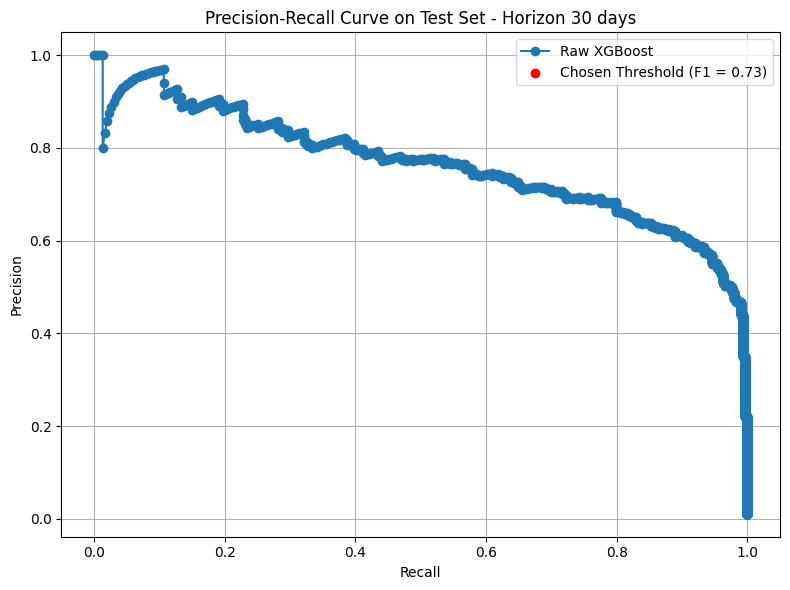

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.38350194692611694

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9973
Accuracy: 0.9931
Precision: 0.6359
Recall: 0.8528
F1 Score: 0.7286
Brier Score: 0.0043
TN: 27137, FP: 146, FN: 44, TP: 255
FNR: 0.1472, FPR: 0.0054


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.3199999928474426

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9957
Accuracy: 0.9929
Precision: 0.6232
Recall: 0.8796
F1 Score: 0.7295
Brier Score: 0.0043
TN: 27124, FP: 159, FN: 36, TP: 263
FNR: 0.1204, FPR: 0.0058


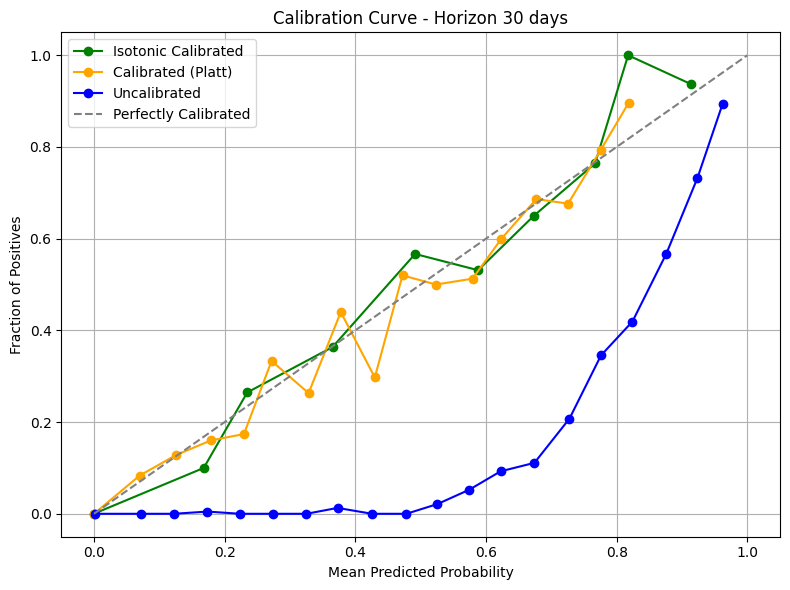

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.898
Average prediction set size: 0.90
set length 1 positives: 4, negatives: 24776, set length 2: 2802
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9850627220651149
Precision: 0.4200848656294201
Recall: 0.9933110367892977
F1 Score: 0.5904572564612326
TN: 26873, FP: 410, FN: 2, TP: 297
Specificity: 0.9850, Sensitivity: 0.9933
====== Metrics on single-label predictions (confident) ======
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
TN: 24776, FP: 0, FN: 0, TP: 4
Specificity: 1.0000, Sensitivity: 1.0000
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9899209629468494
Precision: 0.9565217391304348
Recall: 0.07357859531772576
F1 Score: 0.13664596273291926
TN: 27282, FP: 1, FN: 277, TP: 22
Specificity: 1.0000, Sensitivity: 0.0736

===== XGBoost Training for Horizon 90 days =====
Applying ADASYN f

c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [17:11:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.6695364
Classification report for Horizon 90 days:
               precision    recall  f1-score   support

No Graft Loss       1.00      0.99      0.99     26950
   Graft Loss       0.62      0.80      0.70       632

     accuracy                           0.98     27582
    macro avg       0.81      0.89      0.84     27582
 weighted avg       0.99      0.98      0.99     27582

Brier Score (Raw XGBoost): 0.015952432745993762
ROC AUC (Raw XGBoost): 0.9915254456212865
Accuracy: 0.9840475672540062
Precision: 0.6179361179361179
Recall: 0.7958860759493671
F1 Score: 0.6957123098201936
TN: 26639, FP: 311, FN: 129, TP: 503
FNR: 0.2041, FPR: 0.0115
Specificity: 0.9885, Sensitivity: 0.7959


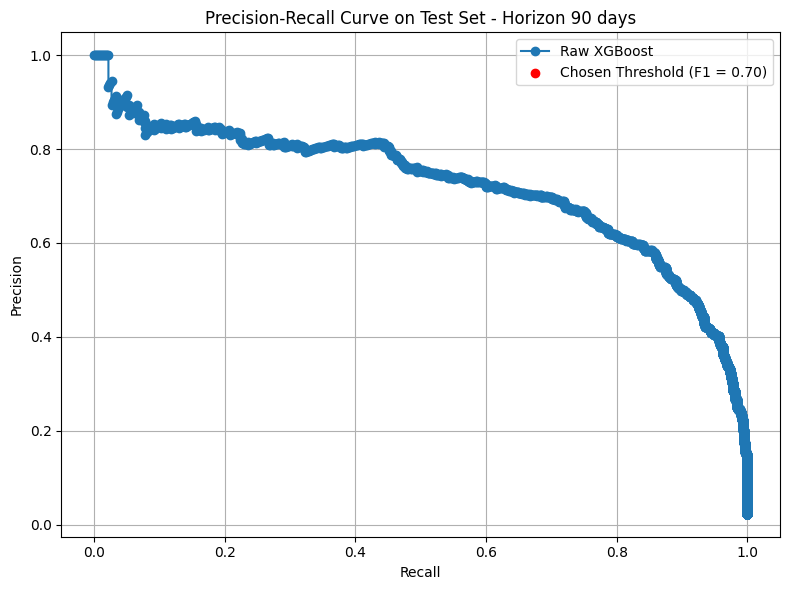

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.2797916829586029

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9915
Accuracy: 0.9840
Precision: 0.6179
Recall: 0.7959
F1 Score: 0.6957
Brier Score: 0.0101
TN: 26639, FP: 311, FN: 129, TP: 503
FNR: 0.2041, FPR: 0.0115


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.30841121077537537

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9908
Accuracy: 0.9826
Precision: 0.5838
Recall: 0.8434
F1 Score: 0.6900
Brier Score: 0.0101
TN: 26570, FP: 380, FN: 99, TP: 533
FNR: 0.1566, FPR: 0.0141


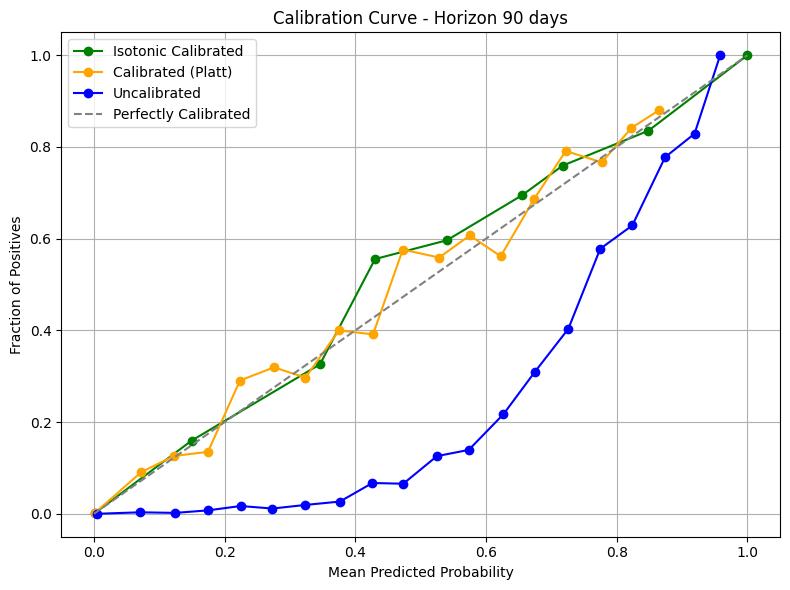

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.900
Average prediction set size: 0.90
set length 1 positives: 299, negatives: 24588, set length 2: 2695
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9731709085635559
Precision: 0.4578125
Recall: 0.9272151898734177
F1 Score: 0.6129707112970711
TN: 26256, FP: 694, FN: 46, TP: 586
Specificity: 0.9742, Sensitivity: 0.9272
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9974685578816249
Precision: 0.802675585284281
Recall: 0.9836065573770492
F1 Score: 0.8839779005524862
TN: 24584, FP: 59, FN: 4, TP: 240
Specificity: 0.9976, Sensitivity: 0.9836
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9843376114857516
Precision: 0.808641975308642
Recall: 0.41455696202531644
F1 Score: 0.5481171548117155
TN: 26888, FP: 62, FN: 370, TP: 262
Specificity: 0.9977, Sensitivity: 0.4146

===== XGBo

c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [17:12:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.61176413
Classification report for Horizon 180 days:
               precision    recall  f1-score   support

No Graft Loss       0.99      0.98      0.99     26656
   Graft Loss       0.59      0.75      0.66       926

     accuracy                           0.97     27582
    macro avg       0.79      0.87      0.82     27582
 weighted avg       0.98      0.97      0.98     27582

Brier Score (Raw XGBoost): 0.025813936625335362
ROC AUC (Raw XGBoost): 0.9834096570593679
Accuracy: 0.9741860633746646
Precision: 0.5909863945578231
Recall: 0.7505399568034558
F1 Score: 0.6612749762131304
TN: 26175, FP: 481, FN: 231, TP: 695
FNR: 0.2495, FPR: 0.0180
Specificity: 0.9820, Sensitivity: 0.7505


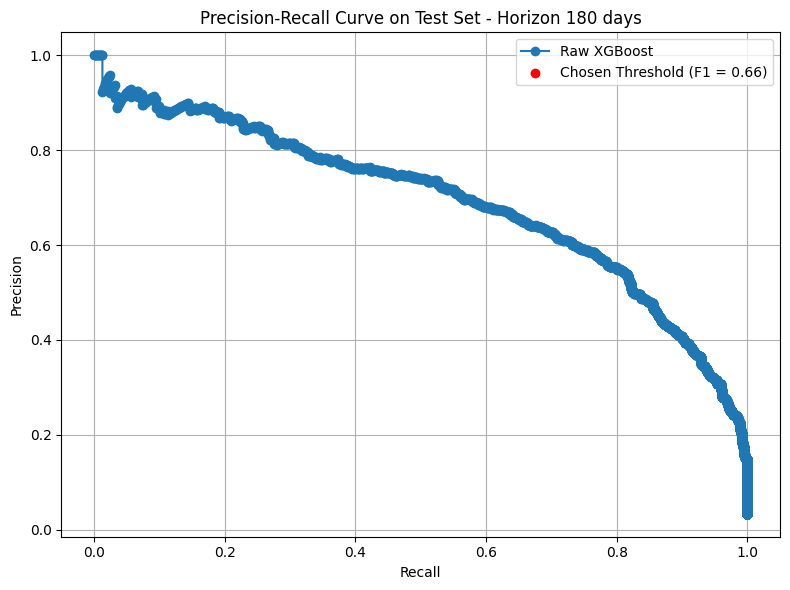

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.28249937295913696

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9834
Accuracy: 0.9742
Precision: 0.5910
Recall: 0.7505
F1 Score: 0.6613
Brier Score: 0.0164
TN: 26175, FP: 481, FN: 231, TP: 695
FNR: 0.2495, FPR: 0.0180


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.2398190051317215

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9833
Accuracy: 0.9716
Precision: 0.5538
Recall: 0.7948
F1 Score: 0.6528
Brier Score: 0.0164
TN: 26063, FP: 593, FN: 190, TP: 736
FNR: 0.2052, FPR: 0.0222


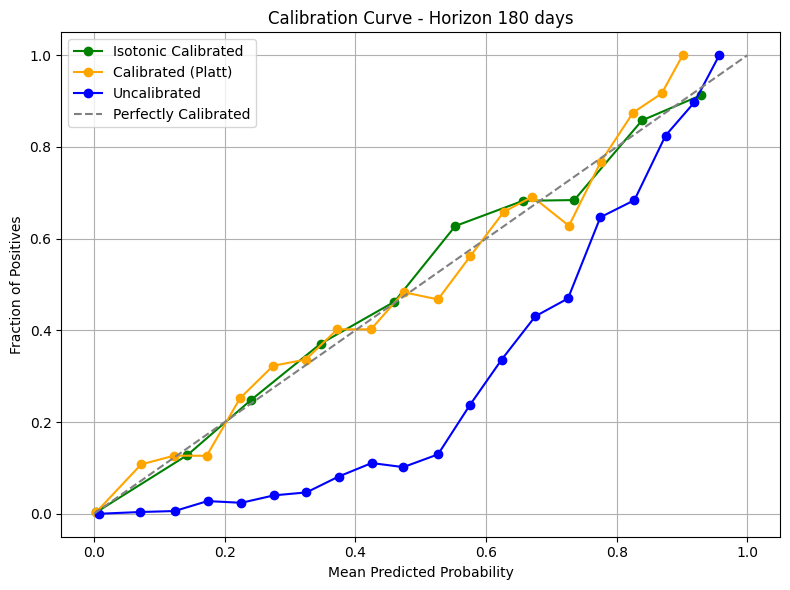

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.901
Average prediction set size: 0.91
set length 1 positives: 612, negatives: 24439, set length 2: 2531
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.964107026321514
Precision: 0.4804161566707466
Recall: 0.847732181425486
F1 Score: 0.61328125
TN: 25807, FP: 849, FN: 141, TP: 785
Specificity: 0.9681, Sensitivity: 0.8477
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9922557981717297
Precision: 0.7418300653594772
Recall: 0.926530612244898
F1 Score: 0.8239564428312159
TN: 24403, FP: 158, FN: 36, TP: 454
Specificity: 0.9936, Sensitivity: 0.9265
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9771590167500543
Precision: 0.7418300653594772
Recall: 0.490280777537797
F1 Score: 0.5903771131339401
TN: 26498, FP: 158, FN: 472, TP: 454
Specificity: 0.9941, Sensitivity: 0.4903

===== XG

c:\Users\sasan\miniconda3\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [17:13:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


Optimal threshold (hybrid F1 + cost): 0.55366635
Classification report for Horizon 360 days:
               precision    recall  f1-score   support

No Graft Loss       0.98      0.98      0.98     26211
   Graft Loss       0.60      0.68      0.64      1371

     accuracy                           0.96     27582
    macro avg       0.79      0.83      0.81     27582
 weighted avg       0.96      0.96      0.96     27582

Brier Score (Raw XGBoost): 0.0383220941193532
ROC AUC (Raw XGBoost): 0.9725137254387964
Accuracy: 0.9616779058806468
Precision: 0.6019480519480519
Recall: 0.6761487964989059
F1 Score: 0.636894537959464
TN: 25598, FP: 613, FN: 444, TP: 927
FNR: 0.3239, FPR: 0.0234
Specificity: 0.9766, Sensitivity: 0.6761


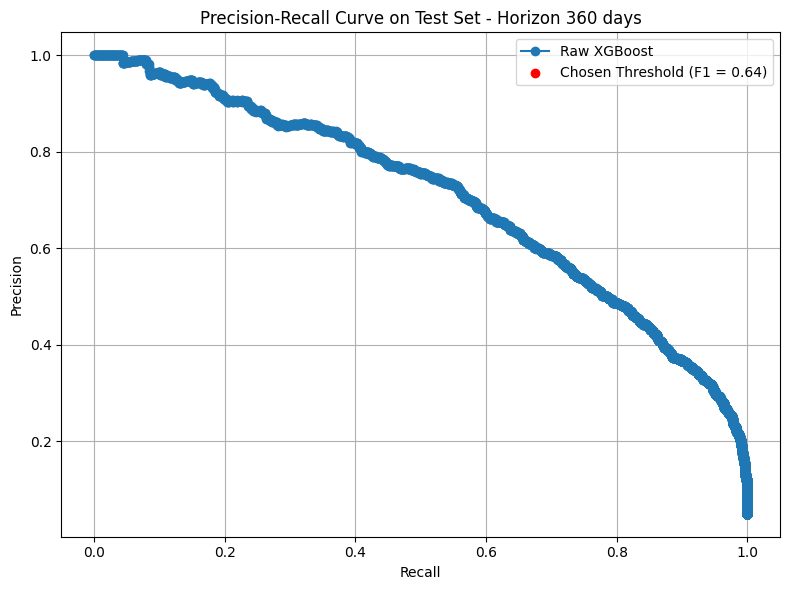

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Platt scaling: 0.29759830236434937

[Test Set Evaluation (Platt Calibrated)]
AUC: 0.9725
Accuracy: 0.9617
Precision: 0.6019
Recall: 0.6761
F1 Score: 0.6369
Brier Score: 0.0248
TN: 25598, FP: 613, FN: 444, TP: 927
FNR: 0.3239, FPR: 0.0234


c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Optimal threshold (hybrid F1 + cost) Isotonic: 0.3016393482685089

[Test Set Evaluation (Isotonic Calibrated)]
AUC: 0.9723
Accuracy: 0.9617
Precision: 0.6019
Recall: 0.6761
F1 Score: 0.6369
Brier Score: 0.0246
TN: 25598, FP: 613, FN: 444, TP: 927
FNR: 0.3239, FPR: 0.0234


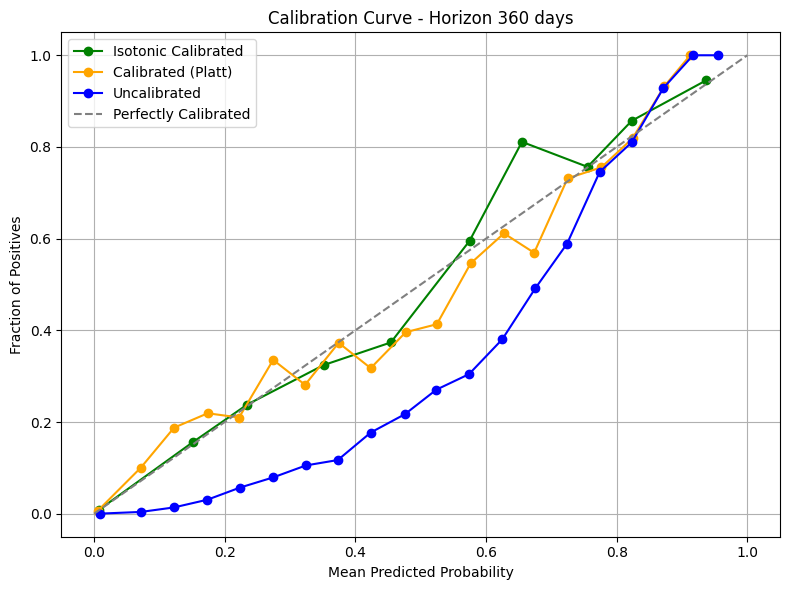

Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...
Prediction set coverage (expected ~0.9): 0.901
Average prediction set size: 0.92
set length 1 positives: 928, negatives: 24314, set length 2: 2340
====== Metrics on single-label predictions (confident + ambigous (default))=======
Accuracy: 0.9570734537016895
Precision: 0.5512890839275919
Recall: 0.7330415754923414
F1 Score: 0.6293049467752035
TN: 25393, FP: 818, FN: 366, TP: 1005
Specificity: 0.9688, Sensitivity: 0.7330
====== Metrics on single-label predictions (confident) ======
Accuracy: 0.9847872593296886
Precision: 0.7510775862068966
Recall: 0.82
F1 Score: 0.7840269966254219
TN: 24161, FP: 231, FN: 153, TP: 697
Specificity: 0.9905, Sensitivity: 0.8200
====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======
Accuracy: 0.9675875571024581
Precision: 0.7345132743362832
Recall: 0.5448577680525164
F1 Score: 0.6256281407035176
TN: 25941, FP: 270, FN: 624, TP: 747
Specificity: 0.9897, Sensitivity: 0.5449


In [ ]:
# graft loss prediction
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, brier_score_loss, confusion_matrix, classification_report
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE, ADASYN
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import joblib


for H in horizons:
    event_name = f'GraftLoss@{H}'
    print(f"\n===== XGBoost Training for Horizon {H} days =====")
    # Convert data to tensors
    X_train = torch.tensor(train_graft_repr_p[H], dtype=torch.float32)
    y_train = torch.tensor(train_graft_lbl_p[H], dtype=torch.float32)

    # Original test set (30% of full data)
    X_test = test_graft_repr[H]
    y_test = test_graft_lbl[H]

    X_val = val_graft_repr[H]
    y_val = val_graft_lbl[H]

    up_sampling_SMOTE = False
    up_sampling_ADASYN = True

    if up_sampling_ADASYN:
        # apply ADASYN
        print("Applying ADASYN for upsampling...")
        smote = ADASYN(random_state=0, sampling_strategy=0.5)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After ADASYN: {X_train.shape}, Positives: {sum(y_train)} ({sum(y_train)/len(y_train):.4f})")
    elif up_sampling_SMOTE:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After SMOTE: {X_train.shape}, Positives: {sum(y_train)} ({sum(y_train)/len(y_train):.4f})")
    else:
        print("No upsampling applied.")

    # Train XGBoost
    xgboost_model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train) / 6,
        eval_metric=['aucpr', 'logloss'],
        objective='binary:logistic',
        random_state=0,
        max_delta_step=10,
    )
    print(f"Scale pos weight: {xgboost_model.get_params()['scale_pos_weight']:.4f}")
    xgboost_model.fit(X_train, y_train)

    # save model
    xgboost_model.save_model(f'../models/{event_name}_xgboost.pkl')

    # Tune threshold on validation set
    y_prob_val = xgboost_model.predict_proba(X_val)[:, 1]
    precision, recall, thresh = precision_recall_curve(y_val, y_prob_val)
    precision = precision[1:]
    recall = recall[1:]

    # F1
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

    # Vectorized cost computation
    y_preds = (y_prob_val[None, :] >= thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    tp = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    fp = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    fn = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    costs = fp * cost_fp + fn * cost_fn

    # Normalize
    f1_norm = f1_scores
    costs_norm = 1 - (costs - np.min(costs)) / (np.max(costs) - np.min(costs))

    # Combine
    alpha = 0.7
    beta = 0.3
    hybrid_score = alpha * f1_norm + beta * costs_norm

    optimal_threshold = thresh[np.argmax(hybrid_score)]
    print("Optimal threshold (hybrid F1 + cost):", optimal_threshold)

    # Predict on xgboost
    y_prob_raw = xgboost_model.predict_proba(X_test)[:, 1]
    y_pred_base = (y_prob_raw >= optimal_threshold).astype(int)
    print(f"Classification report for Horizon {H} days:")
    print(classification_report(y_test, y_pred_base, target_names=['No Graft Loss', 'Graft Loss']))
    print("Brier Score (Raw XGBoost):", brier_score_loss(y_test, y_pred_base))
    print("ROC AUC (Raw XGBoost):", roc_auc_score(y_test, y_prob_raw))
    print("Accuracy:", accuracy_score(y_test, y_pred_base))
    print("Precision:", precision_score(y_test, y_pred_base))
    print("Recall:", recall_score(y_test, y_pred_base))
    print("F1 Score:", f1_score(y_test, y_pred_base))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_base).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"FNR: {fn / (tp + fn):.4f}, FPR: {fp / (tn + fp):.4f}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")

    # plot PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob_raw)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o', label='Raw XGBoost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve on Test Set - Horizon {H} days')
    # Compute metrics at chosen threshold on test set
    precision_test = precision_score(y_test, y_pred_base)
    recall_test = recall_score(y_test, y_pred_base)
    plt.scatter(recall_test, precision_test, color='red', label=f'Chosen Threshold (F1 = {f1_score(y_test, y_pred_base):.2f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Apply Platt scaling (calibration)
    platt_calibrator = CalibratedClassifierCV(xgboost_model, method='sigmoid', cv='prefit')
    platt_calibrator.fit(X_val, y_val)
    y_prob_cal_val = platt_calibrator.predict_proba(X_val)[:, 1]  # Calibrated probs on validation
    y_prob_cal_test = platt_calibrator.predict_proba(X_test)[:, 1]  # Calibrated probs on test

    # save calibrated model
    joblib.dump(platt_calibrator, f'../models/{event_name}_platt.pkl')

    # Debug: Check calibrated probability distribution
    #print(f"Calibrated Probabilities (Test) - Min: {np.min(y_prob_cal_test):.4f}, Max: {np.max(y_prob_cal_test):.4f}")
    #print(f"Calibrated Probabilities (Test) - Histogram: {np.histogram(y_prob_cal_test, bins=10)[0]}")
    
    platt_precision, platt_recall, platt_thresh = precision_recall_curve(y_val, y_prob_cal_val)

    platt_precision = platt_precision[1:]
    platt_recall = platt_recall[1:]

    # F1
    platt_f1_scores = 2 * (platt_precision * platt_recall) / (platt_precision + platt_recall + 1e-10)

    # Vectorized cost computation
    y_preds = (y_prob_cal_val[None, :] >= platt_thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    tp_p = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    fp_p = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    fn_p = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    costs_p = fp_p * cost_fp + fn_p * cost_fn

    # Normalize
    platt_f1_norm = platt_f1_scores
    costs_norm_p = 1 - (costs_p - np.min(costs_p)) / (np.max(costs_p) - np.min(costs_p))

    # Combine
    alpha = 0.7
    beta = 0.3
    hybrid_score_p = alpha * platt_f1_norm + beta * costs_norm_p

    platt_optimal_threshold = platt_thresh[np.argmax(hybrid_score_p)]
    print("Optimal threshold (hybrid F1 + cost) Platt scaling:", platt_optimal_threshold)

    # Evaluate calibrated predictions
    y_pred_cal_test = (y_prob_cal_test >= platt_optimal_threshold).astype(int)
    tn_cal, fp_cal, fn_cal, tp_cal = confusion_matrix(y_test, y_pred_cal_test).ravel()
    print(f"\n[Test Set Evaluation (Platt Calibrated)]")
    print(f"AUC: {roc_auc_score(y_test, y_prob_cal_test):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_cal_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_cal_test, zero_division=0):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob_cal_test):.4f}")
    print(f"TN: {tn_cal}, FP: {fp_cal}, FN: {fn_cal}, TP: {tp_cal}")
    print(f"FNR: {fn_cal / (tp_cal + fn_cal):.4f}, FPR: {fp_cal / (tn_cal + fp_cal):.4f}")

    prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_cal_test, n_bins=20)
    prob_true_orig, prob_pred_orig = calibration_curve(y_test, y_prob_raw, n_bins=20)

    # Try istonic calibration
    iso_calibrator = CalibratedClassifierCV(xgboost_model, method='isotonic', cv='prefit')
    iso_calibrator.fit(X_val, y_val)
    y_prob_isotonic_cal_val = iso_calibrator.predict_proba(X_val)[:, 1]  # Calibrated probs on validation
    y_prob_isotonic_cal_test = iso_calibrator.predict_proba(X_test)[:, 1]  # Calibrated probs on test

    # save isotonic calibrated model
    joblib.dump(iso_calibrator, f'../models/{event_name}_iso.pkl')
    
    iso_precision, iso_recall, iso_thresh = precision_recall_curve(y_val, y_prob_isotonic_cal_val)

    iso_precision = iso_precision[1:]
    iso_recall = iso_recall[1:]

    # F1
    iso_f1_scores = 2 * (iso_precision * iso_recall) / (iso_precision + iso_recall + 1e-10)

    # Vectorized cost computation
    y_preds = (y_prob_isotonic_cal_val[None, :] >= iso_thresh[:, None]).astype(int)
    y_true = y_val[None, :].cpu().numpy()

    iso_tp = np.sum((y_preds == 1) & (y_true == 1), axis=1)
    iso_fp = np.sum((y_preds == 1) & (y_true == 0), axis=1)
    iso_fn = np.sum((y_preds == 0) & (y_true == 1), axis=1)

    cost_fp = 1
    cost_fn = 5
    iso_costs = iso_fp * cost_fp + iso_fn * cost_fn

    # Normalize
    iso_f1_norm = iso_f1_scores
    iso_costs_norm = 1 - (iso_costs - np.min(iso_costs)) / (np.max(iso_costs) - np.min(iso_costs))

    # Combine
    alpha = 0.7
    beta = 0.3
    iso_hybrid_score = alpha * iso_f1_norm + beta * iso_costs_norm

    iso_optimal_threshold = iso_thresh[np.argmax(iso_hybrid_score)]
    print("Optimal threshold (hybrid F1 + cost) Isotonic:", iso_optimal_threshold)

    y_pred_isotonic_cal_test = (y_prob_isotonic_cal_test >= iso_optimal_threshold).astype(int)
    tn_iso, fp_iso, fn_iso, tp_iso = confusion_matrix(y_test, y_pred_isotonic_cal_test).ravel()
    print(f"\n[Test Set Evaluation (Isotonic Calibrated)]")
    print(f"AUC: {roc_auc_score(y_test, y_prob_isotonic_cal_test):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_isotonic_cal_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_isotonic_cal_test, zero_division=0):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob_isotonic_cal_test):.4f}")
    print(f"TN: {tn_iso}, FP: {fp_iso}, FN: {fn_iso}, TP: {tp_iso}")
    print(f"FNR: {fn_iso / (tp_iso + fn_iso):.4f}, FPR: {fp_iso / (tn_iso + fp_iso):.4f}")
    # Plot calibration curve for isotonic regression
    plt.figure(figsize=(8, 6))
    prob_true_iso, prob_pred_iso = calibration_curve(y_test, y_prob_isotonic_cal_test, n_bins=10)
    plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='Isotonic Calibrated', color='green')
    plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated (Platt)', color='orange')
    plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='Uncalibrated', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve - Horizon {H} days')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    threshold_data = {
        'xgboost_threshold': float(optimal_threshold),
        'platt_threshold': float(platt_optimal_threshold),
        'iso_threshold': float(iso_optimal_threshold)
    }
    # Save thresholds as a JSON file
    with open(f'../models/{event_name}_thresholds.json', 'w') as f:
        json.dump(threshold_data, f, indent=4)


    print("Calibrating with Raw XGBoost + Conformal Prediction (MAPIE)...")
    mapie_clf = MapieClassifier(estimator=xgboost_model, cv="prefit", method="lac")
    mapie_clf.fit(X_val, y_val)
    y_pred, y_psets = mapie_clf.predict(X_test, alpha=0.1)
    y_psets = y_psets[:, :, 0]
    y_test = np.array(y_test).astype(int)
    coverage = classification_coverage_score(y_test, y_psets)
    print(f"Prediction set coverage (expected ~0.9): {coverage:.3f}")
    avg_set_size = np.mean(np.sum(y_psets, axis=1))
    print(f"Average prediction set size: {avg_set_size:.2f}")
    set_1_p = 0
    set_1_n = 0
    set_2 = 0

    for i in range(len(y_test)):
        pred_set = y_psets[i]
        labels_in_set = np.where(pred_set)[0]
        if len(labels_in_set) == 1:
            if labels_in_set[0] == 1:
                set_1_p += 1
            else:
                set_1_n += 1
        else:
            set_2 += 1
        
    print(f"set length 1 positives: {set_1_p}, negatives: {set_1_n}, set length 2: {set_2}")

    is_singleton = np.sum(y_psets, axis=1) == 1
    y_pred_filtered = y_pred[is_singleton]
    y_true_filtered = y_test[is_singleton]

    # Metrics for default y_pred
    print("====== Metrics on single-label predictions (confident + ambigous (default))=======")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")

    print("====== Metrics on single-label predictions (confident) ======")
    print("Accuracy:", accuracy_score(y_true_filtered, y_pred_filtered))
    print("Precision:", precision_score(y_true_filtered, y_pred_filtered))
    print("Recall:", recall_score(y_true_filtered, y_pred_filtered))
    print("F1 Score:", f1_score(y_true_filtered, y_pred_filtered))
    tn, fp, fn, tp = confusion_matrix(y_true_filtered, y_pred_filtered).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")

    # Find singleton vs ambiguous predictions
    singleton_mask = np.sum(y_psets, axis=1) == 1

    # Use calibrated model to predict probabilities for uncertain samples
    y_pred_isotonic_cal_test = (y_prob_isotonic_cal_test >= optimal_threshold).astype(int)

    # Combine predictions
    final_preds = np.copy(y_pred)
    final_preds[~singleton_mask] = y_pred_isotonic_cal_test[~singleton_mask]

    # Evaluate
    print("====== Final Evaluation (MAPIE + Isotonic Calibrated Fallback) ======")
    print("Accuracy:", accuracy_score(y_test, final_preds))
    print("Precision:", precision_score(y_test, final_preds))
    print("Recall:", recall_score(y_test, final_preds))
    print("F1 Score:", f1_score(y_test, final_preds))
    tn, fp, fn, tp = confusion_matrix(y_test, final_preds).ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Specificity: {tn / (tn + fp):.4f}, Sensitivity: {tp / (tp + fn):.4f}")


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\sasan\miniconda3\Lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.797e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.560e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\sasan\miniconda3\Lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

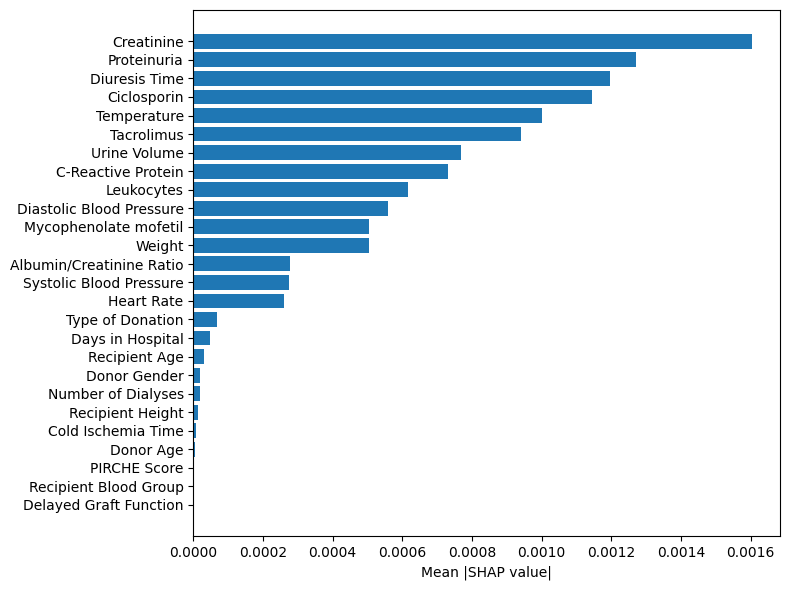

In [ ]:
# grft loss SHAP analysis
import joblib
def flatten_sample(sc, sn, ts_feats):
    """
    Flatten input features to a 1D SHAP-compatible vector.
    """
    sc_np = sc.view(-1).cpu().numpy()
    sn_np = sn.view(-1).cpu().numpy()
    # Ensure ts_feats has the correct shape for reshaping
    ts_np = ts_feats[:, :T, :].reshape(-1).cpu().numpy()

    flat = np.concatenate([sc_np, sn_np, ts_np])
    expected_size = num_cat + num_num + T * num_ts
    assert len(flat) == expected_size
    return flat

def unflatten_sample(flat_vec):
    """
    Reconstruct tensors from flattened vector.
    """
    offset = 0
    sc_np = flat_vec[offset:offset+num_cat].reshape(1, num_cat)
    offset += num_cat

    sn_np = flat_vec[offset:offset+num_num].reshape(1, num_num)
    offset += num_num

    ts_np = flat_vec[offset:offset+T*num_ts].reshape(1, T, num_ts)

    sc_t = torch.tensor(sc_np, dtype=torch.int64)
    sn_t = torch.tensor(sn_np, dtype=torch.float32)
    ts_t = torch.tensor(ts_np, dtype=torch.int64)

    return sc_t, sn_t, ts_t

@torch.no_grad()
def prediction_pipeline(static_num, static_cat, ts_input_data, pre_input, pre_time, post_input, post_time, model, clf_model = None, calibration_model = None):
    # Run forward pass on clf model
    static_num = Variable(_cuda(static_num))
    static_cat = Variable(_cuda(static_cat))

    ts_data = index_value(ts_input_data)

    neib = [index_value(pre_input), Variable(_cuda(pre_time)), 
            index_value(post_input), Variable(_cuda(post_time))]
    
    lstm_out = model(ts_data, neib, static_num, static_cat, get_embedding=True) # (B, T, 2* embedding_dim)

    output = lstm_out[:, T-1, :] # (1, T-1, 2* embedding_dim)

    output_np = output.detach().cpu().numpy().astype(np.float32)
    # (B, 1)
    
    if calibration_model:
        probs = calibration_model.predict_proba(output_np)[:, 1]
    else:
        probs = clf_model.predict_proba(output_np)[:, 1].reshape(-1, 1).flatten()

    return probs

@torch.no_grad()
def pipeline_predict_flat(flat_data, batch_size=32):
    """
    Processes flattened data in batches to avoid CUDA out of memory errors.
    """
    B = flat_data.shape[0]
    all_probs = []

    for i in range(0, B, batch_size):
        batch_end = min(i + batch_size, B)
        batch_data = flat_data[i:batch_end]
        
        sc_list, sn_list, ts_list = [], [], []
        
        for j in range(batch_data.shape[0]):
            sc, sn, ts = unflatten_sample(batch_data[j])
            sc_list.append(sc)
            sn_list.append(sn)
            ts_list.append(ts)
        
        sc_batch = torch.cat(sc_list, dim=0)
        sn_batch = torch.cat(sn_list, dim=0)
        ts_batch = torch.cat(ts_list, dim=0)

        current_batch_size = batch_data.shape[0]
        dummy_pre = torch.zeros((current_batch_size, T, num_ts+1), dtype=torch.int64)
        dummy_time = torch.zeros((current_batch_size, T, num_ts+1), dtype=torch.int64)

        probs = prediction_pipeline(
            static_num=sn_batch, static_cat=sc_batch, ts_input_data=ts_batch,
            pre_input=dummy_pre, pre_time=dummy_time,
            post_input=dummy_pre, post_time=dummy_time,
            model=model, clf_model=None, calibration_model=iso_calibrator
        )
        all_probs.append(probs)

    return np.concatenate(all_probs)

def collect_background_samples(dataloader, num_background=100):
    feats = []
    count = 0
    for batch in dataloader:
        B = batch['static_numerical_features'].size(0)
        for i in range(B):
            if count >= num_background:
                break
            fv = flatten_sample(
                batch['static_categorical_features'][i:i+1],
                batch['static_numerical_features'][i:i+1],
                batch['input_ts_features'][i:i+1]
            )
            feats.append(fv)
            count += 1
        if count >= num_background:
            break
    return np.vstack(feats)

def compute_shap_for_sample(batch_idx, batch, background_feats):
    test_feats = flatten_sample(
        batch['static_categorical_features'][batch_idx:batch_idx+1],
        batch['static_numerical_features'][batch_idx:batch_idx+1],
        batch['input_ts_features'][batch_idx:batch_idx+1]
    ).reshape(1, -1)

    explainer = shap.KernelExplainer(model=pipeline_predict_flat, data=background_feats, link='identity')
    shap_values = explainer.shap_values(test_feats, nsamples=100)

    # Aggregate time series SHAP values per feature (not per time)
    offset_ts = num_cat + num_num
    shap_agg = np.zeros((1, num_cat + num_num + num_ts))

    for c in range(num_cat):
        shap_agg[:, c] = shap_values[:, c]
    for n in range(num_num):
        shap_agg[:, num_cat + n] = shap_values[:, num_cat + n]
    for fidx in range(num_ts):
        idxs = [offset_ts + t * num_ts + fidx for t in range(T)]
        shap_agg[:, num_cat + num_num + fidx] = shap_values[:, idxs].sum(axis=1)

    return shap_agg[0]

def run_shap_analysis(dataloader, background_feats, max_samples=50):
    results = []
    sample_count = 0
    for batch in dataloader:
        B = batch['static_categorical_features'].size(0)
        for i in range(B):
            if sample_count >= max_samples:
                break
            result = compute_shap_for_sample(i, batch, background_feats)
            results.append(result)
            sample_count += 1
        if sample_count >= max_samples:
            break
    return np.vstack(results)

# Run the analysis
# Assuming T, num_cat, num_num, num_ts are defined
# Assuming train_dataloader is defined and other models are loaded
T = 20 # A reasonable value for T
num_cat = len(CONFIG['static_categorical_feat'])
num_num = len(CONFIG['static_numerical_feat'])
num_ts = len(CONFIG['ts_feat'])
ts_size = num_ts * T
iso_calibrator = joblib.load('../models/GraftLoss@30_iso.pkl')
#model = model.to(device)

background_feats = collect_background_samples(train_dataloader, num_background=100)
shap_values = run_shap_analysis(train_dataloader, background_feats, max_samples=50)
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Create feature names
feature_names = (
    CONFIG['static_categorical_feat'] +
    CONFIG['static_numerical_feat'] +
    CONFIG['ts_feat']
)
# Map ATC codes to medication names
feature_map = {
    'L04AA06': 'Mycophenolate mofetil',
    'L04AD02': 'Tacrolimus',
    'L04AD01': 'Ciclosporin',
    'underlying_disease': 'Underlying Disease',
    'type_of_donation': 'Type of Donation', 
    'blood_group': 'Recipient Blood Group',
    'ebv_status': 'EBV Status', 
    'delayed_graft_function': 'Delayed Graft Function',  
    'donor_bloodgroup': 'Donor Blood Group',
    'gender': 'Recipient Gender', 
    'gender_donor': 'Donor Gender',
    'number_dialyses': 'Number of Dialyses', 
    'age': 'Recipient Age', 
    'height': 'Recipient Height', 
    'cold_ischemia_time': 'Cold Ischemia Time',
    'age_donor': 'Donor Age', 
    'days_in_hospital': 'Days in Hospital', 
    'number_transplantation': 'Number of Transplantations',
    'pirche_score': 'PIRCHE Score', 
    'risk_of_graft_failure': 'Risk of Graft Failure',
    'bp_sys': 'Systolic Blood Pressure', 
    'bp_dia': 'Diastolic Blood Pressure', 
    'weight': 'Weight', 
    'urine_volume': 'Urine Volume', 
    'heart_rate': 'Heart Rate', 
    'temperature': 'Temperature', 
    'diuresis_time': 'Diuresis Time', 
    'albumin': 'Albumin/Creatinine Ratio', 
    'crphp': 'C-Reactive Protein',
    'creatinine': 'Creatinine', 
    'leukocyte': 'Leukocytes', 
    'proteinuria': 'Proteinuria', 
}

def format_feature_name(feat):
    return feature_map.get(feat, feat)  # fallback to original name if not in map

# Filter out zero SHAP features
nonzero_mask = mean_abs_shap != 0
mean_abs_shap = mean_abs_shap[nonzero_mask]
feature_names = np.array(feature_names)[nonzero_mask]

    
# Get the sorted indices
sorted_idx = np.argsort(mean_abs_shap)[::-1]

# Generate final mapped labels
# Create a list of mapped feature names based on the original feature names
mapped_feature_names_list = [format_feature_name(feat) for feat in feature_names]

# Sort the mapped names according to the sorted SHAP values
sorted_mapped_names = np.array(mapped_feature_names_list)[sorted_idx]

plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), mean_abs_shap[sorted_idx][::-1])
plt.yticks(range(len(feature_names)), sorted_mapped_names[::-1])
plt.xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.828e-06, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

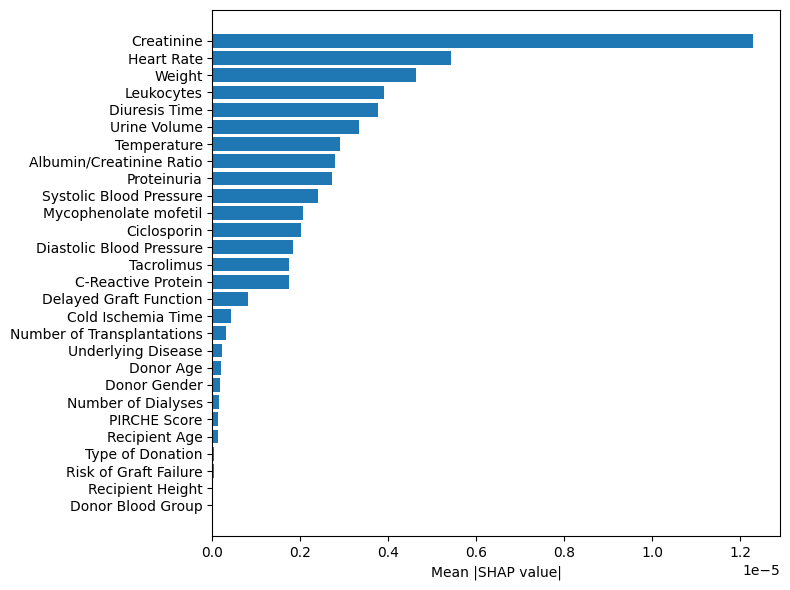

In [ ]:
# rejection SHAP analysis
import joblib
def flatten_sample(sc, sn, ts_feats):
    """
    Flatten input features to a 1D SHAP-compatible vector.
    """
    sc_np = sc.view(-1).cpu().numpy()
    sn_np = sn.view(-1).cpu().numpy()
    # Ensure ts_feats has the correct shape for reshaping
    ts_np = ts_feats[:, :T, :].reshape(-1).cpu().numpy()

    flat = np.concatenate([sc_np, sn_np, ts_np])
    expected_size = num_cat + num_num + T * num_ts
    assert len(flat) == expected_size
    return flat

def unflatten_sample(flat_vec):
    """
    Reconstruct tensors from flattened vector.
    """
    offset = 0
    sc_np = flat_vec[offset:offset+num_cat].reshape(1, num_cat)
    offset += num_cat

    sn_np = flat_vec[offset:offset+num_num].reshape(1, num_num)
    offset += num_num

    ts_np = flat_vec[offset:offset+T*num_ts].reshape(1, T, num_ts)

    sc_t = torch.tensor(sc_np, dtype=torch.int64)
    sn_t = torch.tensor(sn_np, dtype=torch.float32)
    ts_t = torch.tensor(ts_np, dtype=torch.int64)

    return sc_t, sn_t, ts_t

@torch.no_grad()
def prediction_pipeline(static_num, static_cat, ts_input_data, pre_input, pre_time, post_input, post_time, model, clf_model = None, calibration_model = None):
    # Run forward pass on clf model
    static_num = Variable(_cuda(static_num))
    static_cat = Variable(_cuda(static_cat))

    ts_data = index_value(ts_input_data)

    neib = [index_value(pre_input), Variable(_cuda(pre_time)), 
            index_value(post_input), Variable(_cuda(post_time))]
    
    lstm_out = model(ts_data, neib, static_num, static_cat, get_embedding=True) # (B, T, 2* embedding_dim)

    output = lstm_out[:, T-1, :] # (1, T-1, 2* embedding_dim)

    output_np = output.detach().cpu().numpy().astype(np.float32)
    # (B, 1)
    
    if calibration_model:
        probs = calibration_model.predict_proba(output_np)[:, 1]
    else:
        probs = clf_model.predict_proba(output_np)[:, 1].reshape(-1, 1).flatten()

    return probs

@torch.no_grad()
def pipeline_predict_flat(flat_data, batch_size=32):
    """
    Processes flattened data in batches to avoid CUDA out of memory errors.
    """
    B = flat_data.shape[0]
    all_probs = []

    for i in range(0, B, batch_size):
        batch_end = min(i + batch_size, B)
        batch_data = flat_data[i:batch_end]
        
        sc_list, sn_list, ts_list = [], [], []
        
        for j in range(batch_data.shape[0]):
            sc, sn, ts = unflatten_sample(batch_data[j])
            sc_list.append(sc)
            sn_list.append(sn)
            ts_list.append(ts)
        
        sc_batch = torch.cat(sc_list, dim=0)
        sn_batch = torch.cat(sn_list, dim=0)
        ts_batch = torch.cat(ts_list, dim=0)

        current_batch_size = batch_data.shape[0]
        dummy_pre = torch.zeros((current_batch_size, T, num_ts+1), dtype=torch.int64)
        dummy_time = torch.zeros((current_batch_size, T, num_ts+1), dtype=torch.int64)

        probs = prediction_pipeline(
            static_num=sn_batch, static_cat=sc_batch, ts_input_data=ts_batch,
            pre_input=dummy_pre, pre_time=dummy_time,
            post_input=dummy_pre, post_time=dummy_time,
            model=model, clf_model=None, calibration_model=iso_calibrator
        )
        all_probs.append(probs)

    return np.concatenate(all_probs)

def collect_background_samples(dataloader, num_background=100):
    feats = []
    count = 0
    for batch in dataloader:
        B = batch['static_numerical_features'].size(0)
        for i in range(B):
            if count >= num_background:
                break
            fv = flatten_sample(
                batch['static_categorical_features'][i:i+1],
                batch['static_numerical_features'][i:i+1],
                batch['input_ts_features'][i:i+1]
            )
            feats.append(fv)
            count += 1
        if count >= num_background:
            break
    return np.vstack(feats)

def compute_shap_for_sample(batch_idx, batch, background_feats):
    test_feats = flatten_sample(
        batch['static_categorical_features'][batch_idx:batch_idx+1],
        batch['static_numerical_features'][batch_idx:batch_idx+1],
        batch['input_ts_features'][batch_idx:batch_idx+1]
    ).reshape(1, -1)

    explainer = shap.KernelExplainer(model=pipeline_predict_flat, data=background_feats, link='identity')
    shap_values = explainer.shap_values(test_feats, nsamples=100)

    # Aggregate time series SHAP values per feature (not per time)
    offset_ts = num_cat + num_num
    shap_agg = np.zeros((1, num_cat + num_num + num_ts))

    for c in range(num_cat):
        shap_agg[:, c] = shap_values[:, c]
    for n in range(num_num):
        shap_agg[:, num_cat + n] = shap_values[:, num_cat + n]
    for fidx in range(num_ts):
        idxs = [offset_ts + t * num_ts + fidx for t in range(T)]
        shap_agg[:, num_cat + num_num + fidx] = shap_values[:, idxs].sum(axis=1)

    return shap_agg[0]

def run_shap_analysis(dataloader, background_feats, max_samples=50):
    results = []
    sample_count = 0
    for batch in dataloader:
        B = batch['static_categorical_features'].size(0)
        for i in range(B):
            if sample_count >= max_samples:
                break
            result = compute_shap_for_sample(i, batch, background_feats)
            results.append(result)
            sample_count += 1
        if sample_count >= max_samples:
            break
    return np.vstack(results)

# Run the analysis
# Assuming T, num_cat, num_num, num_ts are defined
# Assuming train_dataloader is defined and other models are loaded
T = 20 # A reasonable value for T
num_cat = len(CONFIG['static_categorical_feat'])
num_num = len(CONFIG['static_numerical_feat'])
num_ts = len(CONFIG['ts_feat'])
ts_size = num_ts * T
iso_calibrator = joblib.load('../models/Rejection@30_iso.pkl')
model = model.to(device)

background_feats = collect_background_samples(train_dataloader, num_background=100)
shap_values = run_shap_analysis(train_dataloader, background_feats, max_samples=50)
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Create feature names
feature_names = (
    CONFIG['static_categorical_feat'] +
    CONFIG['static_numerical_feat'] +
    CONFIG['ts_feat']
)
# Map ATC codes to medication names
feature_map = {
    'L04AA06': 'Mycophenolate mofetil',
    'L04AD02': 'Tacrolimus',
    'L04AD01': 'Ciclosporin',
    'underlying_disease': 'Underlying Disease',
    'type_of_donation': 'Type of Donation', 
    'blood_group': 'Recipient Blood Group',
    'ebv_status': 'EBV Status', 
    'delayed_graft_function': 'Delayed Graft Function',  
    'donor_bloodgroup': 'Donor Blood Group',
    'gender': 'Recipient Gender', 
    'gender_donor': 'Donor Gender',
    'number_dialyses': 'Number of Dialyses', 
    'age': 'Recipient Age', 
    'height': 'Recipient Height', 
    'cold_ischemia_time': 'Cold Ischemia Time',
    'age_donor': 'Donor Age', 
    'days_in_hospital': 'Days in Hospital', 
    'number_transplantation': 'Number of Transplantations',
    'pirche_score': 'PIRCHE Score', 
    'risk_of_graft_failure': 'Risk of Graft Failure',
    'bp_sys': 'Systolic Blood Pressure', 
    'bp_dia': 'Diastolic Blood Pressure', 
    'weight': 'Weight', 
    'urine_volume': 'Urine Volume', 
    'heart_rate': 'Heart Rate', 
    'temperature': 'Temperature', 
    'diuresis_time': 'Diuresis Time', 
    'albumin': 'Albumin/Creatinine Ratio', 
    'crphp': 'C-Reactive Protein',
    'creatinine': 'Creatinine', 
    'leukocyte': 'Leukocytes', 
    'proteinuria': 'Proteinuria', 
}

def format_feature_name(feat):
    return feature_map.get(feat, feat)  # fallback to original name if not in map

# Filter out zero SHAP features
nonzero_mask = mean_abs_shap != 0
mean_abs_shap = mean_abs_shap[nonzero_mask]
feature_names = np.array(feature_names)[nonzero_mask]

    
# Get the sorted indices
sorted_idx = np.argsort(mean_abs_shap)[::-1]

# Generate final mapped labels
# Create a list of mapped feature names based on the original feature names
mapped_feature_names_list = [format_feature_name(feat) for feat in feature_names]

# Sort the mapped names according to the sorted SHAP values
sorted_mapped_names = np.array(mapped_feature_names_list)[sorted_idx]

plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), mean_abs_shap[sorted_idx][::-1])
plt.yticks(range(len(feature_names)), sorted_mapped_names[::-1])
plt.xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\sasan\miniconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.266e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

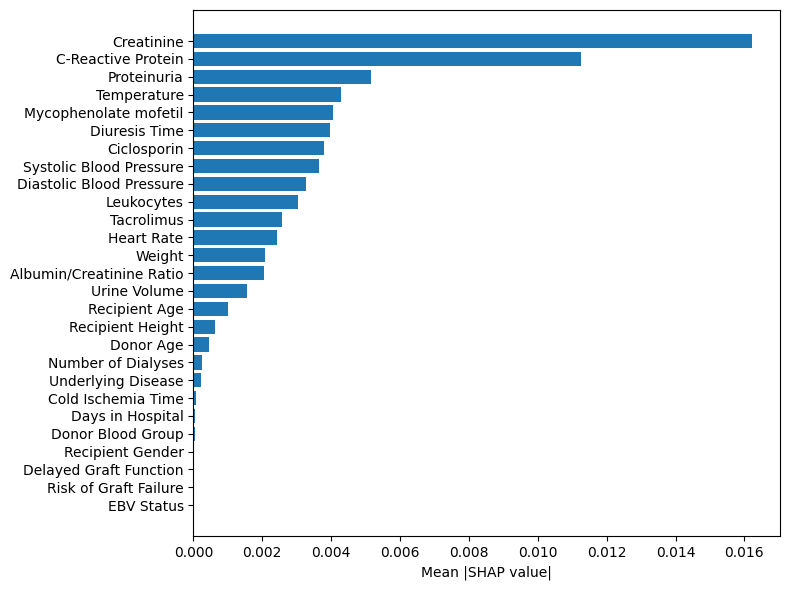

In [ ]:
# mortality SHAP analysis
import joblib
def flatten_sample(sc, sn, ts_feats):
    """
    Flatten input features to a 1D SHAP-compatible vector.
    """
    sc_np = sc.view(-1).cpu().numpy()
    sn_np = sn.view(-1).cpu().numpy()
    # Ensure ts_feats has the correct shape for reshaping
    ts_np = ts_feats[:, :T, :].reshape(-1).cpu().numpy()

    flat = np.concatenate([sc_np, sn_np, ts_np])
    expected_size = num_cat + num_num + T * num_ts
    assert len(flat) == expected_size
    return flat

def unflatten_sample(flat_vec):
    """
    Reconstruct tensors from flattened vector.
    """
    offset = 0
    sc_np = flat_vec[offset:offset+num_cat].reshape(1, num_cat)
    offset += num_cat

    sn_np = flat_vec[offset:offset+num_num].reshape(1, num_num)
    offset += num_num

    ts_np = flat_vec[offset:offset+T*num_ts].reshape(1, T, num_ts)

    sc_t = torch.tensor(sc_np, dtype=torch.int64)
    sn_t = torch.tensor(sn_np, dtype=torch.float32)
    ts_t = torch.tensor(ts_np, dtype=torch.int64)

    return sc_t, sn_t, ts_t

@torch.no_grad()
def prediction_pipeline(static_num, static_cat, ts_input_data, pre_input, pre_time, post_input, post_time, model, clf_model = None, calibration_model = None):
    # Run forward pass on clf model
    static_num = Variable(_cuda(static_num))
    static_cat = Variable(_cuda(static_cat))

    ts_data = index_value(ts_input_data)

    neib = [index_value(pre_input), Variable(_cuda(pre_time)), 
            index_value(post_input), Variable(_cuda(post_time))]
    
    lstm_out = model(ts_data, neib, static_num, static_cat, get_embedding=True) # (B, T, 2* embedding_dim)

    output = lstm_out[:, T-1, :] # (1, T-1, 2* embedding_dim)

    output_np = output.detach().cpu().numpy().astype(np.float32)
    # (B, 1)
    
    if calibration_model:
        probs = calibration_model.predict_proba(output_np)[:, 1]
    else:
        probs = clf_model.predict_proba(output_np)[:, 1].reshape(-1, 1).flatten()  # Convert to numpy array and flatten

    return probs

@torch.no_grad()
def pipeline_predict_flat(flat_data, batch_size=32):
    """
    Processes flattened data in batches to avoid CUDA out of memory errors.
    """
    B = flat_data.shape[0]
    all_probs = []

    for i in range(0, B, batch_size):
        batch_end = min(i + batch_size, B)
        batch_data = flat_data[i:batch_end]
        
        sc_list, sn_list, ts_list = [], [], []
        
        for j in range(batch_data.shape[0]):
            sc, sn, ts = unflatten_sample(batch_data[j])
            sc_list.append(sc)
            sn_list.append(sn)
            ts_list.append(ts)
        
        sc_batch = torch.cat(sc_list, dim=0)
        sn_batch = torch.cat(sn_list, dim=0)
        ts_batch = torch.cat(ts_list, dim=0)

        current_batch_size = batch_data.shape[0]
        dummy_pre = torch.zeros((current_batch_size, T, num_ts+1), dtype=torch.int64)
        dummy_time = torch.zeros((current_batch_size, T, num_ts+1), dtype=torch.int64)

        probs = prediction_pipeline(
            static_num=sn_batch, static_cat=sc_batch, ts_input_data=ts_batch,
            pre_input=dummy_pre, pre_time=dummy_time,
            post_input=dummy_pre, post_time=dummy_time,
            model=model, clf_model=None, calibration_model=iso_calibrator
        )
        all_probs.append(probs)

    return np.concatenate(all_probs)

def collect_background_samples(dataloader, num_background=100):
    feats = []
    count = 0
    for batch in dataloader:
        B = batch['static_numerical_features'].size(0)
        for i in range(B):
            if count >= num_background:
                break
            fv = flatten_sample(
                batch['static_categorical_features'][i:i+1],
                batch['static_numerical_features'][i:i+1],
                batch['input_ts_features'][i:i+1]
            )
            feats.append(fv)
            count += 1
        if count >= num_background:
            break
    return np.vstack(feats)

def compute_shap_for_sample(batch_idx, batch, background_feats):
    test_feats = flatten_sample(
        batch['static_categorical_features'][batch_idx:batch_idx+1],
        batch['static_numerical_features'][batch_idx:batch_idx+1],
        batch['input_ts_features'][batch_idx:batch_idx+1]
    ).reshape(1, -1)

    explainer = shap.KernelExplainer(model=pipeline_predict_flat, data=background_feats, link='identity')
    shap_values = explainer.shap_values(test_feats, nsamples=100)

    # Aggregate time series SHAP values per feature (not per time)
    offset_ts = num_cat + num_num
    shap_agg = np.zeros((1, num_cat + num_num + num_ts))

    for c in range(num_cat):
        shap_agg[:, c] = shap_values[:, c]
    for n in range(num_num):
        shap_agg[:, num_cat + n] = shap_values[:, num_cat + n]
    for fidx in range(num_ts):
        idxs = [offset_ts + t * num_ts + fidx for t in range(T)]
        shap_agg[:, num_cat + num_num + fidx] = shap_values[:, idxs].sum(axis=1)

    return shap_agg[0]

def run_shap_analysis(dataloader, background_feats, max_samples=50):
    results = []
    sample_count = 0
    for batch in dataloader:
        B = batch['static_categorical_features'].size(0)
        for i in range(B):
            if sample_count >= max_samples:
                break
            result = compute_shap_for_sample(i, batch, background_feats)
            results.append(result)
            sample_count += 1
        if sample_count >= max_samples:
            break
    return np.vstack(results)

# Run the analysis
# Assuming T, num_cat, num_num, num_ts are defined
# Assuming train_dataloader is defined and other models are loaded
T = 20 # A reasonable value for T
num_cat = len(CONFIG['static_categorical_feat'])
num_num = len(CONFIG['static_numerical_feat'])
num_ts = len(CONFIG['ts_feat'])
ts_size = num_ts * T
iso_calibrator = joblib.load('../models/Mortality@30_iso.pkl')
model = model.to(device)

background_feats = collect_background_samples(train_dataloader, num_background=100)
shap_values = run_shap_analysis(train_dataloader, background_feats, max_samples=50)
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Create feature names
feature_names = (
    CONFIG['static_categorical_feat'] +
    CONFIG['static_numerical_feat'] +
    CONFIG['ts_feat']
)
# Map ATC codes to medication names
feature_map = {
    'L04AA06': 'Mycophenolate mofetil',
    'L04AD02': 'Tacrolimus',
    'L04AD01': 'Ciclosporin',
    'underlying_disease': 'Underlying Disease',
    'type_of_donation': 'Type of Donation', 
    'blood_group': 'Recipient Blood Group',
    'ebv_status': 'EBV Status', 
    'delayed_graft_function': 'Delayed Graft Function',  
    'donor_bloodgroup': 'Donor Blood Group',
    'gender': 'Recipient Gender', 
    'gender_donor': 'Donor Gender',
    'number_dialyses': 'Number of Dialyses', 
    'age': 'Recipient Age', 
    'height': 'Recipient Height', 
    'cold_ischemia_time': 'Cold Ischemia Time',
    'age_donor': 'Donor Age', 
    'days_in_hospital': 'Days in Hospital', 
    'number_transplantation': 'Number of Transplantations',
    'pirche_score': 'PIRCHE Score', 
    'risk_of_graft_failure': 'Risk of Graft Failure',
    'bp_sys': 'Systolic Blood Pressure', 
    'bp_dia': 'Diastolic Blood Pressure', 
    'weight': 'Weight', 
    'urine_volume': 'Urine Volume', 
    'heart_rate': 'Heart Rate', 
    'temperature': 'Temperature', 
    'diuresis_time': 'Diuresis Time', 
    'albumin': 'Albumin/Creatinine Ratio', 
    'crphp': 'C-Reactive Protein',
    'creatinine': 'Creatinine', 
    'leukocyte': 'Leukocytes', 
    'proteinuria': 'Proteinuria', 
}

def format_feature_name(feat):
    return feature_map.get(feat, feat)  # fallback to original name if not in map

# Filter out zero SHAP features
nonzero_mask = mean_abs_shap != 0
mean_abs_shap = mean_abs_shap[nonzero_mask]
feature_names = np.array(feature_names)[nonzero_mask]
    
# Get the sorted indices
sorted_idx = np.argsort(mean_abs_shap)[::-1]

# Generate final mapped labels
# Create a list of mapped feature names based on the original feature names
mapped_feature_names_list = [format_feature_name(feat) for feat in feature_names]

# Sort the mapped names according to the sorted SHAP values
sorted_mapped_names = np.array(mapped_feature_names_list)[sorted_idx]

plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), mean_abs_shap[sorted_idx][::-1])
plt.yticks(range(len(feature_names)), sorted_mapped_names[::-1])
plt.xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.show()
